In [1]:
#%reload_ext autoreload
#%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters, SGXConverter
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

In [4]:
SGXConverter.convert_sgx_to_csv()

Found 0 SGX files.
Found 103 CSV files. Proceeding with analysis...


# Read Data

Let's first read in the meta data of all models in the dataset.

In [5]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|█████████████████████████████████████████| 103/103 [02:44<00:00,  1.60s/it]


revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba744cbcafb46c2a52482e36498a9bf  301bfb5af53c431a830a6e435de6a590   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba744cbcafb46c2a52482e36498a9bf  8af3fc1bb4b74e7c8c4089e4921d9056   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   

                                             datetime description  \
model_id                                                            
1ba74449e9354d0c9d4798b4a6e915d0  2019-03-19 11:36:50         NaN   
1ba744cbcafb46c2a52482e36498a9bf  2020-03-23 17:26:03         NaN   
1ba7587b3191422fb03a0e9ba92cebff  2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc  2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b  2020-06-30 07:12:48         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba744cbcafb46c2a52482e36498a9bf                  Receipt of Application  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba744cbcafb46c2a52482e36498a9bf  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [6]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [7]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [8]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

471496

This is the percentage of example process from the dataset:

In [9]:
len(df_meta_examples)/len(df_meta)

0.4615853019811625

This is the number of models in the dataset without example processes (again, based on process names):

In [10]:
len(df_meta)-len(df_meta_examples)

549975

And the percentage of models in the dataset without example processes:

In [11]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5384146980188376

We apply the filter to perform the analysis on the dataset without examples processes:

In [12]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

549975

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [13]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [14]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
#df_notations = df_notations.replace({'Notation' : d_namespaces})

In [15]:
def map_namespaces(namespace):
    return d_namespaces.get(namespace, 'Unknown')
df_notations['Notation'] = df_notations['Notation'].map(lambda x: map_namespaces(x))
df_notations

Notation  Frequency
0                         BPMN 2.0     404243
1                              EPC      32339
2                      Value Chain      22857
3                         BPMN 1.1      15636
4                    UML 2.2 Class      14953
5                          DMN 1.0      12612
6                        Petri Net      11207
7                    ArchiMate 2.1      10956
8                     UML Use Case      10228
9                       Organigram       4568
10           BPMN 2.0 Choreography       4096
11           BPMN 2.0 Conversation       2788
12               FMC Block Diagram       1398
13                        CMMN 1.0        999
14                             CPN        385
15                     Journey Map        287
16                        YAWL 2.2        238
17  Process Documentation Template         86
18                          jBPM 4         76
19                          XForms         20
20                   Chen Notation          3

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
if df_notations['Notation'].nunique() > 3:
    df_notations = DataFilter(df_notations)
    df_notations = df_notations.filter_data("namespaces", "max", 100)
df_notations

Notation  Frequency
0                BPMN 2.0     404243
1                     EPC      32339
2             Value Chain      22857
3                BPMN 1.1      15636
4           UML 2.2 Class      14953
5                 DMN 1.0      12612
6               Petri Net      11207
7           ArchiMate 2.1      10956
8            UML Use Case      10228
9              Organigram       4568
10  BPMN 2.0 Choreography       4096
11  BPMN 2.0 Conversation       2788
12      FMC Block Diagram       1398
13               CMMN 1.0        999
14                    CPN        385
15            Journey Map        287
16               YAWL 2.2        238
17                  Other        185

We can visualise the number of models in different modeling notations.

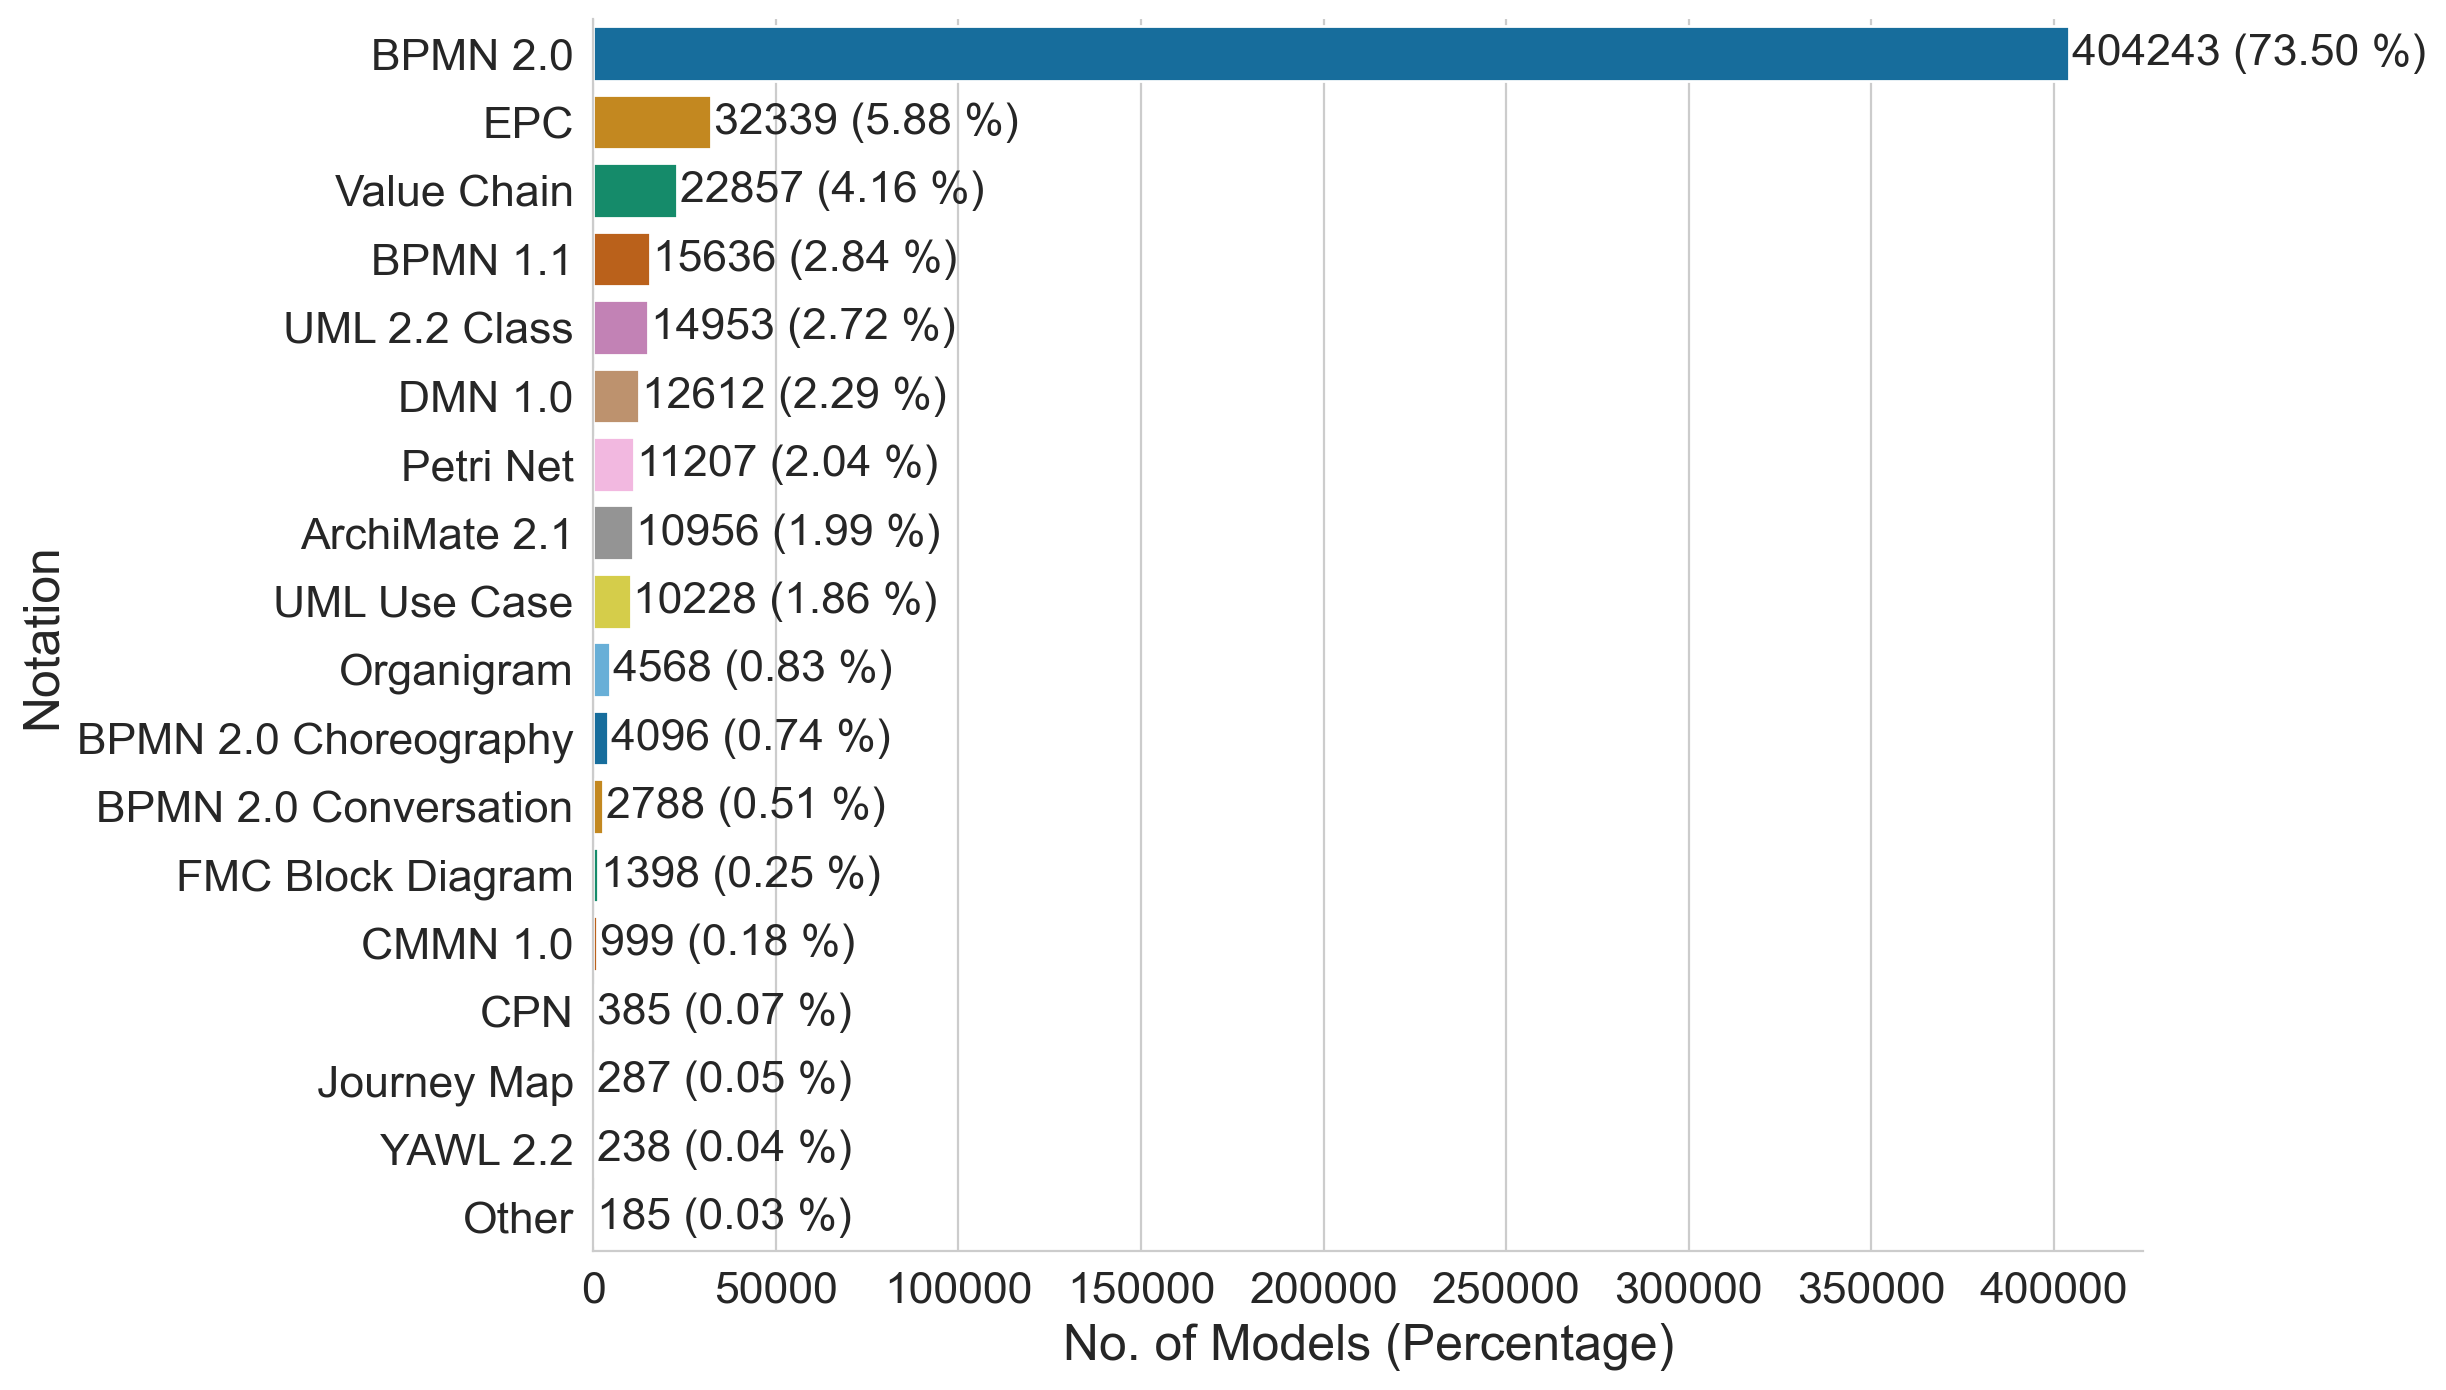

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
#ax=sns.barplot(x="Frequency", y="Notation", hue="Notation", data=df_notations, estimator = np.max, errorbar=('ci', 0), legend=False)
sns.despine()
ax.bar_label(ax.containers[0], label_type='edge', padding=1, labels=[f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
# ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  43fe80a91c114d3ca121e8e8fb03a0a6   

                                                   organization_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
c1f9781d06594f068bee14f96d6744f3 2011-12-01 23:11:10         NaN   

                                              name       type  \
model_id                                                        
c1f9781d06594f068bee14f96d6744f3  Ampel - Lösung 1  Petrinets   

                                                             namespace  
model_id                                                                
c1f9781d06594f068bee14f96d6744f3  http://b3mn.org/stencilset/petrinet#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
0507df8deb7847e0a97d7515663e168d  9c6d4bceab634d7ca854edb71d3b5f0b   

                                                   organization_id  \
model_id                                                             
0507df8deb7847e0a97d7515663e168d  30da146aae4842cfab909b9723944f7a   

                                            datetime description  \
model_id                                                           
0507df8deb7847e0a97d7515663e168d 2021-09-22 03:19:14         NaN   

                                                                          name  \
model_id                                                                         
0507df8deb7847e0a97d7515663e168d  OSPCC Related Queries-As-Is Model  (Updated)   

                                 type                            namespace  
model_id                                                                    
0507df8deb7847e0a97d7515663e168d  NaN  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#     404243
1                  http://b3mn.org/stencilset/epc#      32339
2  http://www.signavio.com/stencilsets/processmap#      22857
3              http://b3mn.org/stencilset/bpmn1.1#      15636
4          http://b3mn.org/stencilset/UML2.2Class#      14953

In [22]:
#handling the case where we have unknown namespaces in the dataset
#to inspect the unknown namespaces, comment the following line out:
#print(df_meta['namespace'].value_counts())
namespaces = mappings['namespaces'].keys()
df_meta['namespace'] = df_meta['namespace'].apply(lambda x: x if x in namespaces else 'Unknown')

In [23]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [24]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum().reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [25]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

namespace   Count  Year
0   UML 2.2 Class       0  2012
1   UML 2.2 Class       0  2013
2   UML 2.2 Class       0  2014
3   UML 2.2 Class     193  2015
4   UML 2.2 Class    1127  2016
5   UML 2.2 Class    1773  2017
6   UML 2.2 Class    1669  2018
7   UML 2.2 Class    1174  2019
8   UML 2.2 Class    3860  2020
9   UML 2.2 Class    5157  2021
10       BPMN 1.1       0  2012
11       BPMN 1.1       0  2013
12       BPMN 1.1       0  2014
13       BPMN 1.1     205  2015
14       BPMN 1.1     596  2016
15       BPMN 1.1    1400  2017
16       BPMN 1.1    2418  2018
17       BPMN 1.1    2200  2019
18       BPMN 1.1    3421  2020
19       BPMN 1.1    5396  2021
20       BPMN 2.0       4  2012
21       BPMN 2.0       0  2013
22       BPMN 2.0       0  2014
23       BPMN 2.0    4391  2015
24       BPMN 2.0   17867  2016
25       BPMN 2.0   39066  2017
26       BPMN 2.0   66351  2018
27       BPMN 2.0   81634  2019
28       BPMN 2.0   93875  2020
29       BPMN 2.0  101055  2021
30            EPC       0  2012
31            EPC       1  2013
32            EPC       0  2014
33            EPC    1451  2015
34            EPC    2617  2016
35            EPC    4806  2017
36            EPC    6163  2018
37            EPC    5646  2019
38            EPC    7403  2020
39            EPC    4252  2021
40    Value Chain       0  2012
41    Value Chain       0  2013
42    Value Chain       0  2014
43    Value Chain     288  2015
44    Value Chain    1389  2016
45    Value Chain    2247  2017
46    Value Chain    4462  2018
47    Value Chain    3901  2019
48    Value Chain    6627  2020
49    Value Chain    3943  2021

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [26]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

24

In [27]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2024]
#df_meta_selected.head()
df_meta_selected

namespace   Count  Year
3   UML 2.2 Class     193  2015
4   UML 2.2 Class    1127  2016
5   UML 2.2 Class    1773  2017
6   UML 2.2 Class    1669  2018
7   UML 2.2 Class    1174  2019
8   UML 2.2 Class    3860  2020
9   UML 2.2 Class    5157  2021
13       BPMN 1.1     205  2015
14       BPMN 1.1     596  2016
15       BPMN 1.1    1400  2017
16       BPMN 1.1    2418  2018
17       BPMN 1.1    2200  2019
18       BPMN 1.1    3421  2020
19       BPMN 1.1    5396  2021
23       BPMN 2.0    4391  2015
24       BPMN 2.0   17867  2016
25       BPMN 2.0   39066  2017
26       BPMN 2.0   66351  2018
27       BPMN 2.0   81634  2019
28       BPMN 2.0   93875  2020
29       BPMN 2.0  101055  2021
33            EPC    1451  2015
34            EPC    2617  2016
35            EPC    4806  2017
36            EPC    6163  2018
37            EPC    5646  2019
38            EPC    7403  2020
39            EPC    4252  2021
43    Value Chain     288  2015
44    Value Chain    1389  2016
45    Value Chain    2247  2017
46    Value Chain    4462  2018
47    Value Chain    3901  2019
48    Value Chain    6627  2020
49    Value Chain    3943  2021

In [28]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

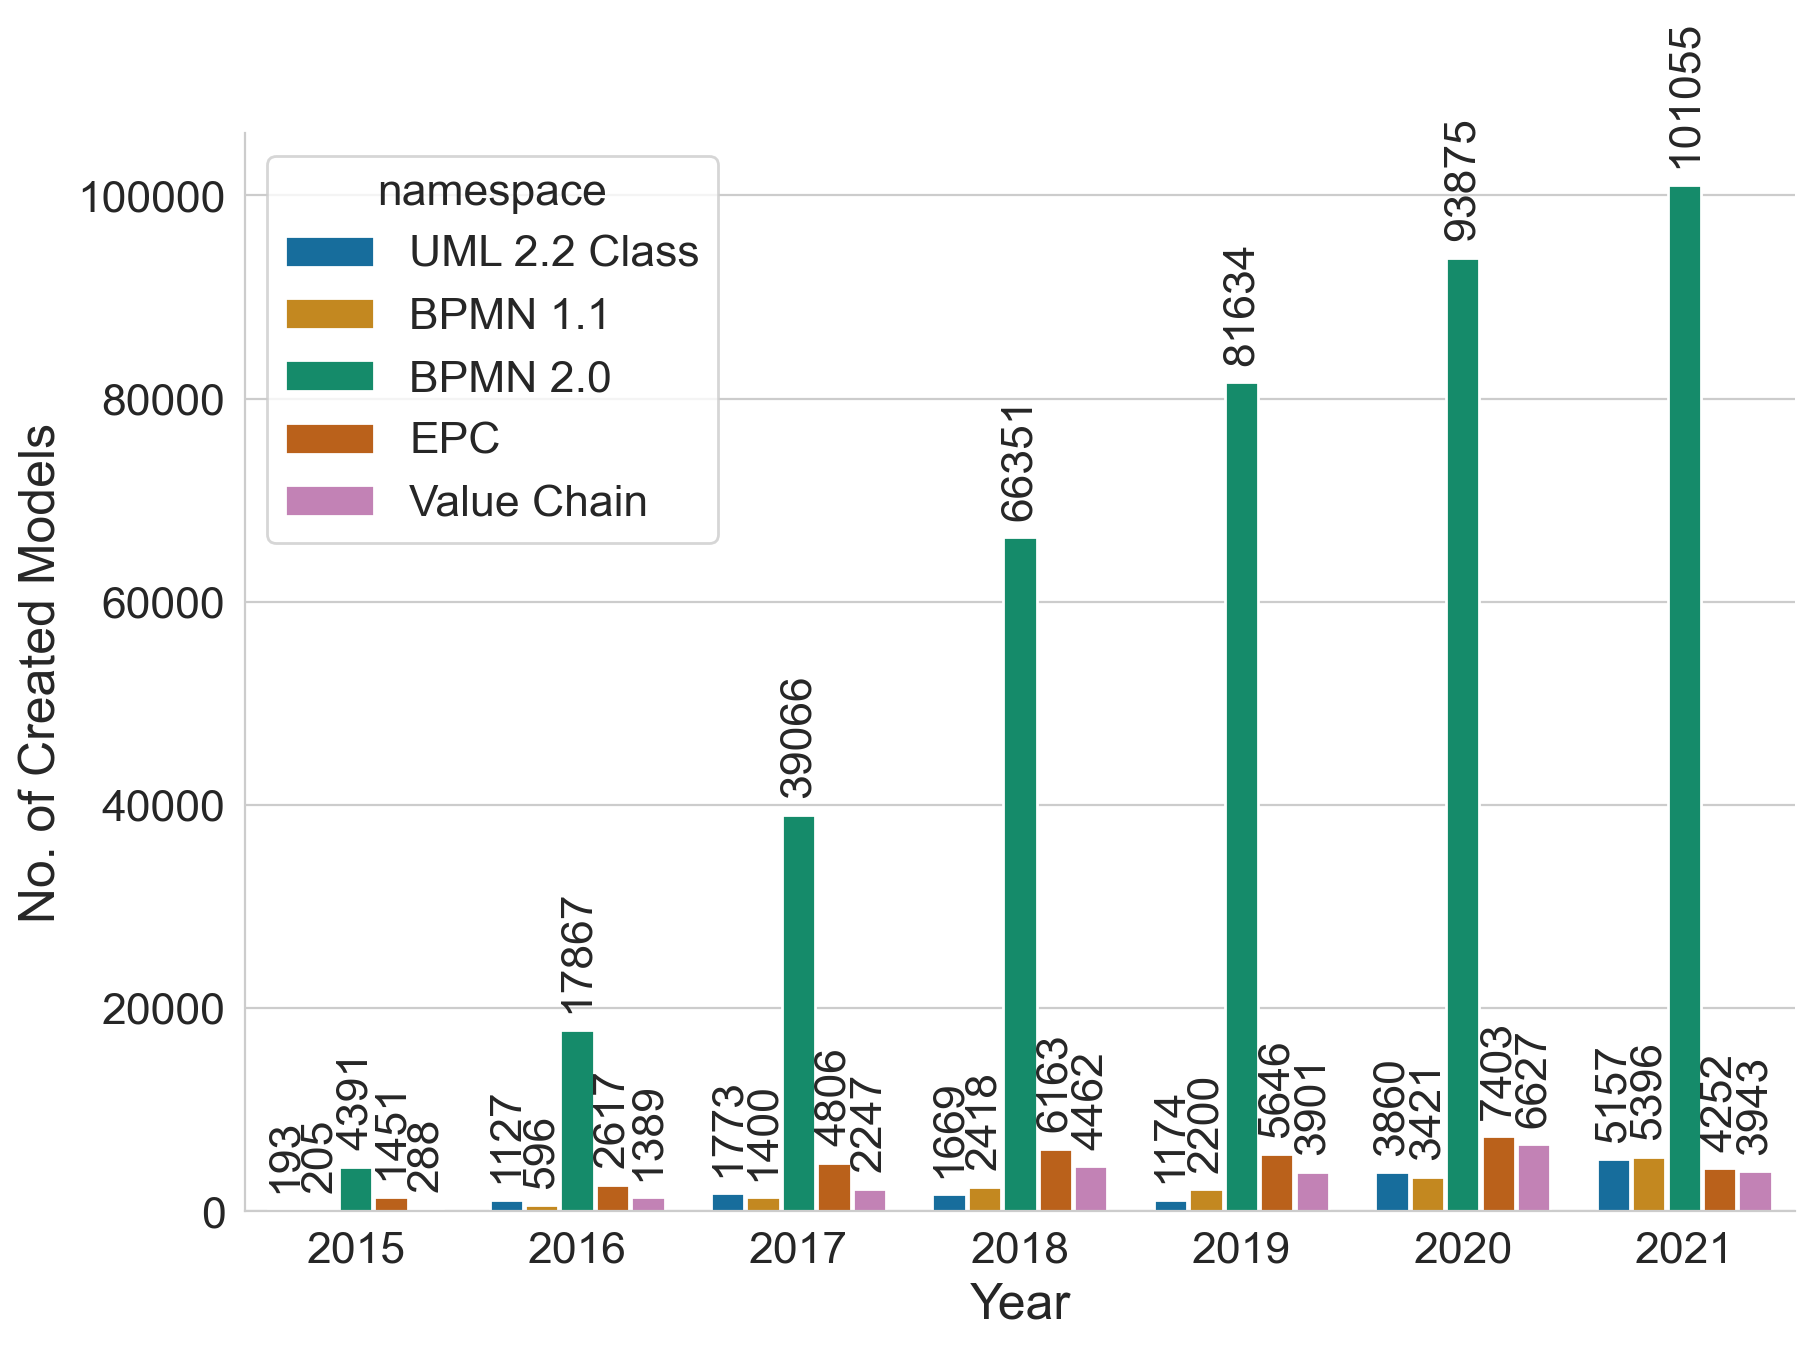

In [29]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax,palette=sns.color_palette("colorblind"))
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [30]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0   EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2021    101055  4252         3943      5396           5157
2020     93875  7403         6627      3421           3860
2019     81634  5646         3901      2200           1174
2018     66351  6163         4462      2418           1669
2017     39066  4806         2247      1400           1773
2016     17867  2617         1389       596           1127
2015      4391  1451          288       205            193

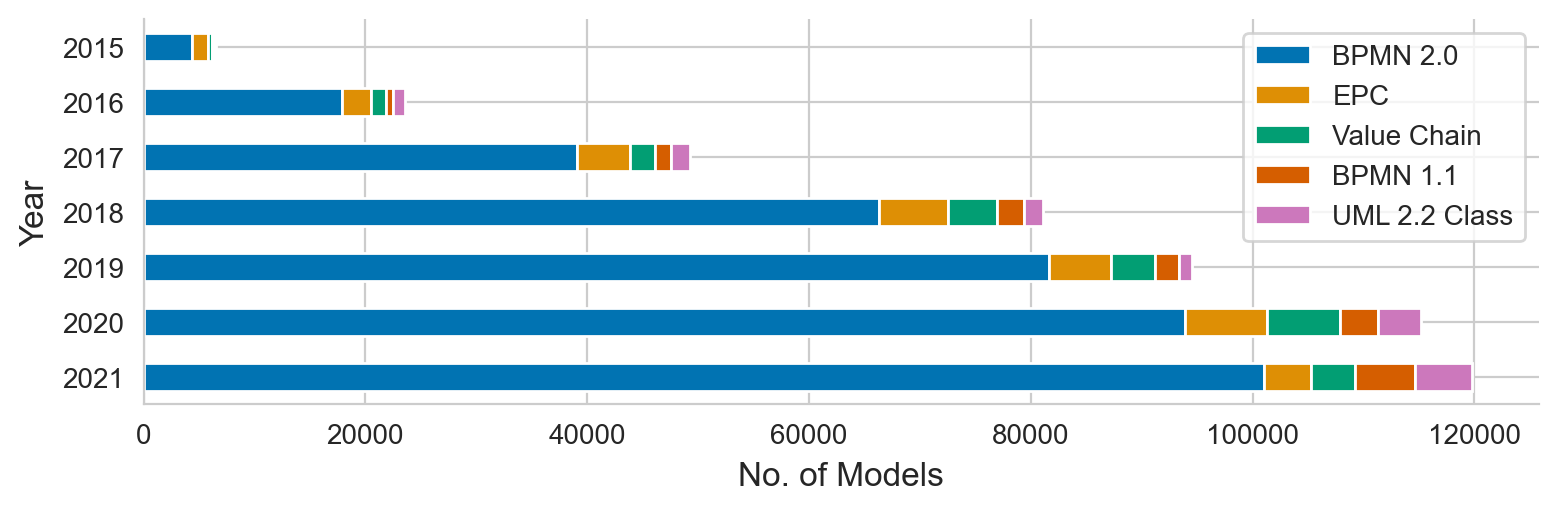

In [31]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [32]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   
1ba7b40cfd804781a4aaa394635d1760  e47efaa6dcde4a4586b7ffcb301996d5   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   
1ba7b40cfd804781a4aaa394635d1760  c41660388a04449a995dccf97d894f46   

                                            datetime description  \
model_id                                                           
1ba74449e9354d0c9d4798b4a6e915d0 2019-03-19 11:36:50         NaN   
1ba7587b3191422fb03a0e9ba92cebff 2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc 2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b 2020-06-30 07:12:48         NaN   
1ba7b40cfd804781a4aaa394635d1760 2019-06-12 03:11:21         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4  NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#  
1ba7b40cfd804781a4aaa394635d1760  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [33]:
len(df_meta_bpmn)

404243

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [34]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|█████████████████████████████████████████| 103/103 [20:52<00:00, 12.16s/it]


category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                           name  
model_id                         element_id                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  Pivo  
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Pivo  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  Pivo

In [35]:
df_meta_bpmn.head()

revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   
1ba7b40cfd804781a4aaa394635d1760  e47efaa6dcde4a4586b7ffcb301996d5   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   
1ba7b40cfd804781a4aaa394635d1760  c41660388a04449a995dccf97d894f46   

                                            datetime description  \
model_id                                                           
1ba74449e9354d0c9d4798b4a6e915d0 2019-03-19 11:36:50         NaN   
1ba7587b3191422fb03a0e9ba92cebff 2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc 2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b 2020-06-30 07:12:48         NaN   
1ba7b40cfd804781a4aaa394635d1760 2019-06-12 03:11:21         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4  NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#  
1ba7b40cfd804781a4aaa394635d1760  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models from the parser:

In [36]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

605506

Number of BPMN 2.0 models from the parser after filtering out example processes:

In [37]:
df_bpmn = DataFilter(df_bpmn)
df_bpmn = df_bpmn.filter_data("example_processes")
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

390954

When compared to the analysis of the dataset metadata, we notice the count of BPMN 2.0 models is slightly lower. This difference shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements, and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [38]:
len(df_bpmn)

19798495

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [39]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    #!pip install update -U pydantic==1.10.8
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✓ Download and installation successful


In [40]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|█████████████████████████████████| 390954/390954 [1:46:51<00:00, 60.97it/s]


label  \
model_id                                                                              
1ba74449e9354d0c9d4798b4a6e915d0   Konobar\n Narudžba primljena\n Narudžba / kup...   
1ba7587b3191422fb03a0e9ba92cebff   Yes No Organization\n Employee Meeting confir...   
1ba758f87e744ff0bcb3119887cac8cc   A student visits ACBT Direct to ECU SL Direct...   
1ba77121c3be44d6bd0b354727f9707b   Kunde  "DESADV"\n geht ein Auftrags-\nE-Mail ...   
1ba7b40cfd804781a4aaa394635d1760   Event Administrator Publish Event Customise E...   

                                                                    name  \
model_id                                                                   
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen    
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4   

                                 detected_natural_language  
model_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0                        hr  
1ba7587b3191422fb03a0e9ba92cebff                        en  
1ba758f87e744ff0bcb3119887cac8cc                        en  
1ba77121c3be44d6bd0b354727f9707b                        de  
1ba7b40cfd804781a4aaa394635d1760                        en

Let's plot the use of different languages across the dataset.

In [41]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [42]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English         188603
1                       German         103546
2                      Italian          19331
3                      Spanish          17305
4                       French           9424
5                     Croatian           8323
6                   Portuguese           6676
7                     Estonian           4893
8                        Dutch           4859
9                    Slovenian           4147
10  Unknown language [UNKNOWN]           4000
11                    Romanian           3392
12                  Indonesian           3036
13                     Swedish           2298
14                      Polish           1576
15                   Hungarian           1542
16                       Greek           1498
17                      Danish            650
18                     Catalan            565
19                   Norwegian            558
20                     Finnish            446
21                   Afrikaans            442
22                  Vietnamese            431
23                       Welsh            430
24                     Turkish            415
25                    Japanese            394
26                       Czech            289
27                     Latvian            280
28                     Tagalog            275
29    Unknown language [zh-cn]            212
30                      Somali            204
31                      Slovak            204
32                    Albanian            184
33                     Russian            168
34                      Korean            110
35                  Macedonian             81
36                  Lithuanian             75
37                     Swahili             45
38                     Persian             38
39                      Arabic              4
40                        Thai              2
41                   Bulgarian              2
42                   Ukrainian              1

We only plot the 10 most common languages.

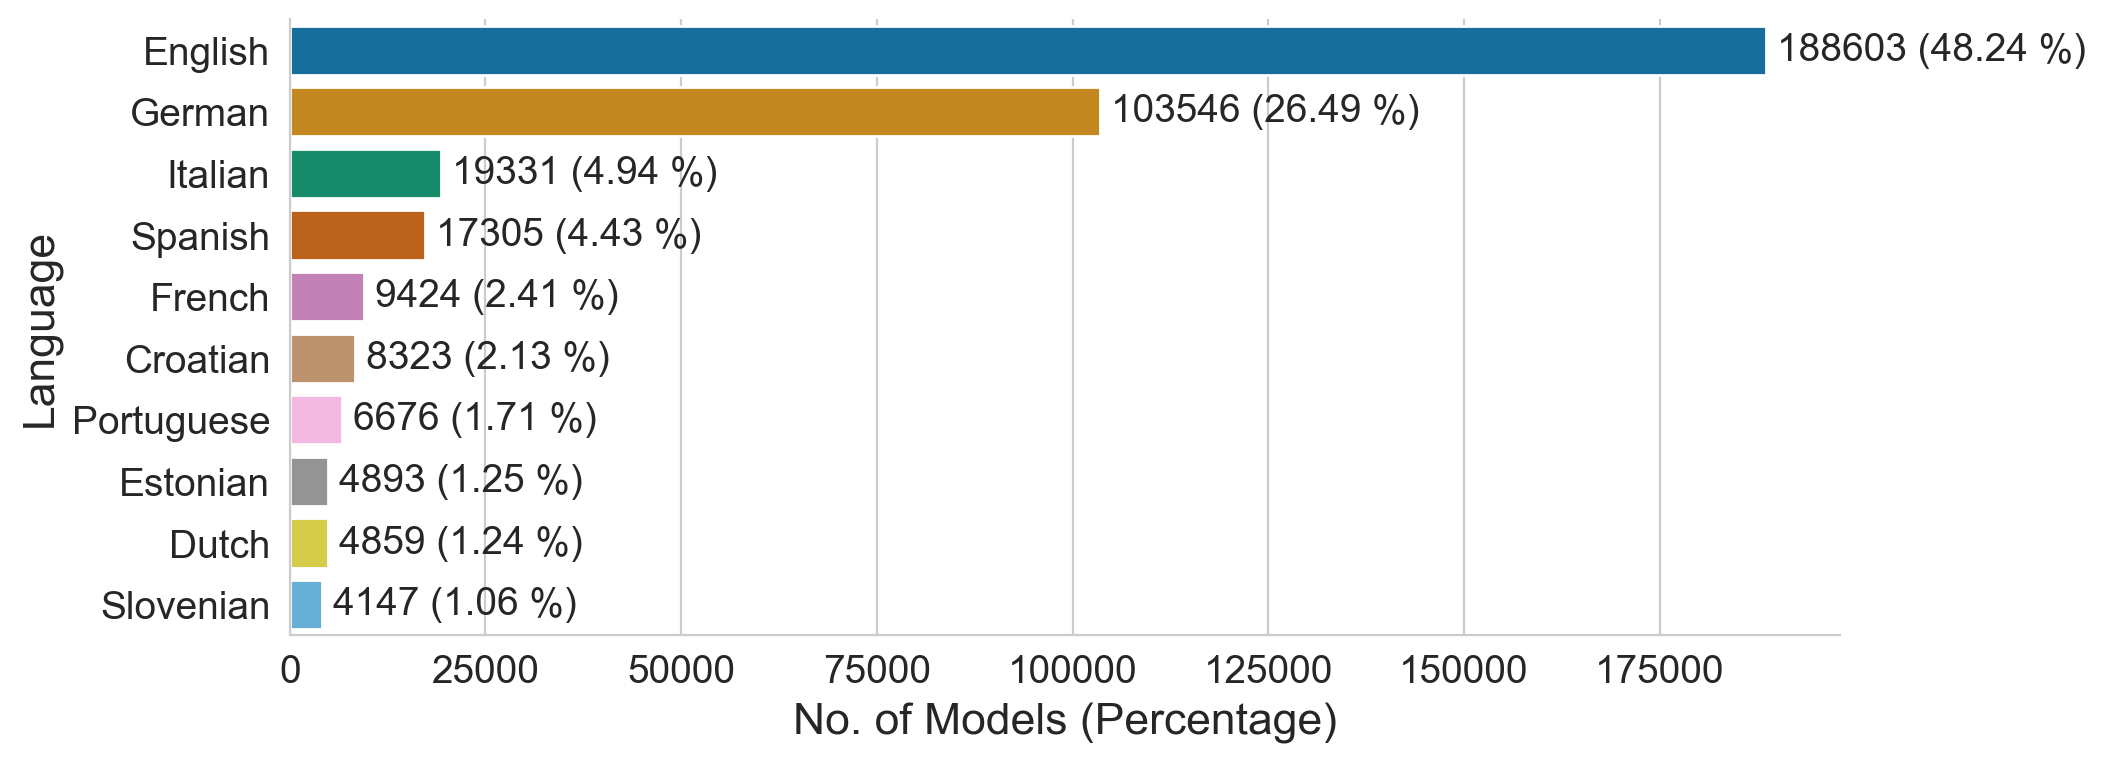

In [43]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", data=df_lang,palette=sns.color_palette("colorblind"))
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']])
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [44]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [45]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|█████████████████████████████████| 390954/390954 [3:13:00<00:00, 33.76it/s]


MessageFlow  Pool  Lane  StartMessageEvent  SequenceFlow  \
0            1     2     2                  1             2   
1            0     1     3                  0            17   
2            0     0     0                  0             6   
3            1     2     5                  0            25   
4            0     1     1                  0             5   

   EventbasedGateway  Task  StartNoneEvent  total_count  EndNoneEvent  \
0                  1     2               1           12             0   
1                  0    12               1           38             2   
2                  0     6               0           13             0   
3                  0    12               1           66             4   
4                  0     0               1           13             1   

   Exclusive_Databased_Gateway  Association_Undirected  \
0                            0                       0   
1                            2                       0   
2                            1                       0   
3                            0                       2   
4                            0                       0   

   Association_Unidirectional  IntermediateMessageEventCatching  \
0                           0                                 0   
1                           0                                 0   
2                           0                                 0   
3                           1                                 1   
4                           0                                 0   

   IntermediateMessageEventThrowing  ITSystem  ParallelGateway  \
0                                 0         0                0   
1                                 0         0                0   
2                                 0         0                0   
3                                 2         2                3   
4                                 0         0                0   

   StartConditionalEvent  DataObject  IntermediateConditionalEvent  \
0                      0           0                             0   
1                      0           0                             0   
2                      0           0                             0   
3                      3           1                             1   
4                      0           0                             0   

   CollapsedSubprocess  EndTerminateEvent  IntermediateTimerEvent  \
0                    0                  0                       0   
1                    0                  0                       0   
2                    0                  0                       0   
3                    0                  0                       0   
4                    4                  0                       0   

   CollapsedPool  TextAnnotation  Subprocess  IntermediateEvent  \
0              0               0           0                  0   
1              0               0           0                  0   
2              0               0           0                  0   
3              0               0           0                  0   
4              0               0           0                  0   

   InclusiveGateway  DataStore  EndMessageEvent  EventSubprocess  \
0                 0          0                0                0   
1                 0          0                0                0   
2                 0          0                0                0   
3                 0          0                0                0   
4                 0          0                0                0   

   StartTimerEvent  IntermediateErrorEvent  IntermediateLinkEventCatching  \
0                0                       0                              0   
1                0                       0                              0   
2                0                       0                              0   
3                0                       0                              0   
4  

These are the statistics of the different element types per model:

In [46]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    390954.000000
mean          9.947464
std           4.159732
min           1.000000
25%           7.000000
50%           9.000000
75%          13.000000
max          62.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [47]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
0000150e890c45928d26584d491ada68                          0   
00003a67300748639e4bc21398bb5ede                          0   
00005cea16fd426881c7f1619e30b804                          0   
0000c8488ca54f7cafe9556e9538defd                          0   
00011e4ecbf740d4bd4dd71a5c845c4d                          0   

category                          Association_Undirected  \
model_id                                                   
0000150e890c45928d26584d491ada68                       0   
00003a67300748639e4bc21398bb5ede                       0   
00005cea16fd426881c7f1619e30b804                       2   
0000c8488ca54f7cafe9556e9538defd                       1   
00011e4ecbf740d4bd4dd71a5c845c4d                       0   

category                          Association_Unidirectional  \
model_id                                                       
0000150e890c45928d26584d491ada68                           0   
00003a67300748639e4bc21398bb5ede                           0   
00005cea16fd426881c7f1619e30b804                           0   
0000c8488ca54f7cafe9556e9538defd                           2   
00011e4ecbf740d4bd4dd71a5c845c4d                           2   

category                          ChoreographyParticipant  ChoreographyTask  \
model_id                                                                      
0000150e890c45928d26584d491ada68                        0                 0   
00003a67300748639e4bc21398bb5ede                        0                 0   
00005cea16fd426881c7f1619e30b804                        0                 0   
0000c8488ca54f7cafe9556e9538defd                        0                 0   
00011e4ecbf740d4bd4dd71a5c845c4d                        0                 0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
0000150e890c45928d26584d491ada68                         0              0   
00003a67300748639e4bc21398bb5ede                         0              0   
00005cea16fd426881c7f1619e30b804                         0              0   
0000c8488ca54f7cafe9556e9538defd                         0              0   
00011e4ecbf740d4bd4dd71a5c845c4d                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
0000150e890c45928d26584d491ada68                    0                      0   
00003a67300748639e4bc21398bb5ede                    0                      0   
00005cea16fd426881c7f1619e30b804                    0                      0   
0000c8488ca54f7cafe9556e9538defd                    0                      0   
00011e4ecbf740d4bd4dd71a5c845c4d                    0                      0   

category                          Communication  ComplexGateway  \
model_id                                                          
0000150e890c45928d26584d491ada68              0               0   
00003a67300748639e4bc21398bb5ede              0               0   
00005cea16fd426881c7f1619e30b804              0               0   
0000c8488ca54f7cafe9556e9538defd              0               0   
00011e4ecbf740d4bd4dd71a5c845c4d              0               0   

category                          ConversationLink  DataObject  DataStore  \
model_id                                                                    
0000150e890c45928d26584d491ada68                 0           0          0   
00003a67300748639e4bc21398bb5ede                 0           0          0   
00005cea16fd426881c7f1619e30b804                 0           0          0   
0000c8488ca54f7cafe9556e9538defd                 0           2          0   
00011e4ecbf740d4bd4dd71a5c845c4d                 0           1          1   

category               

In [48]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [49]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
len(df_freq[df_freq["frequency"]/len(df_cnts) < 0.1])

53

In [50]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())
df_freq.head()

category  frequency
0                  Sequence flow     384161
1                           Task     379507
2                 End none event     344426
3               Start none event     299014
4  Exclusive  databased  gateway     292880

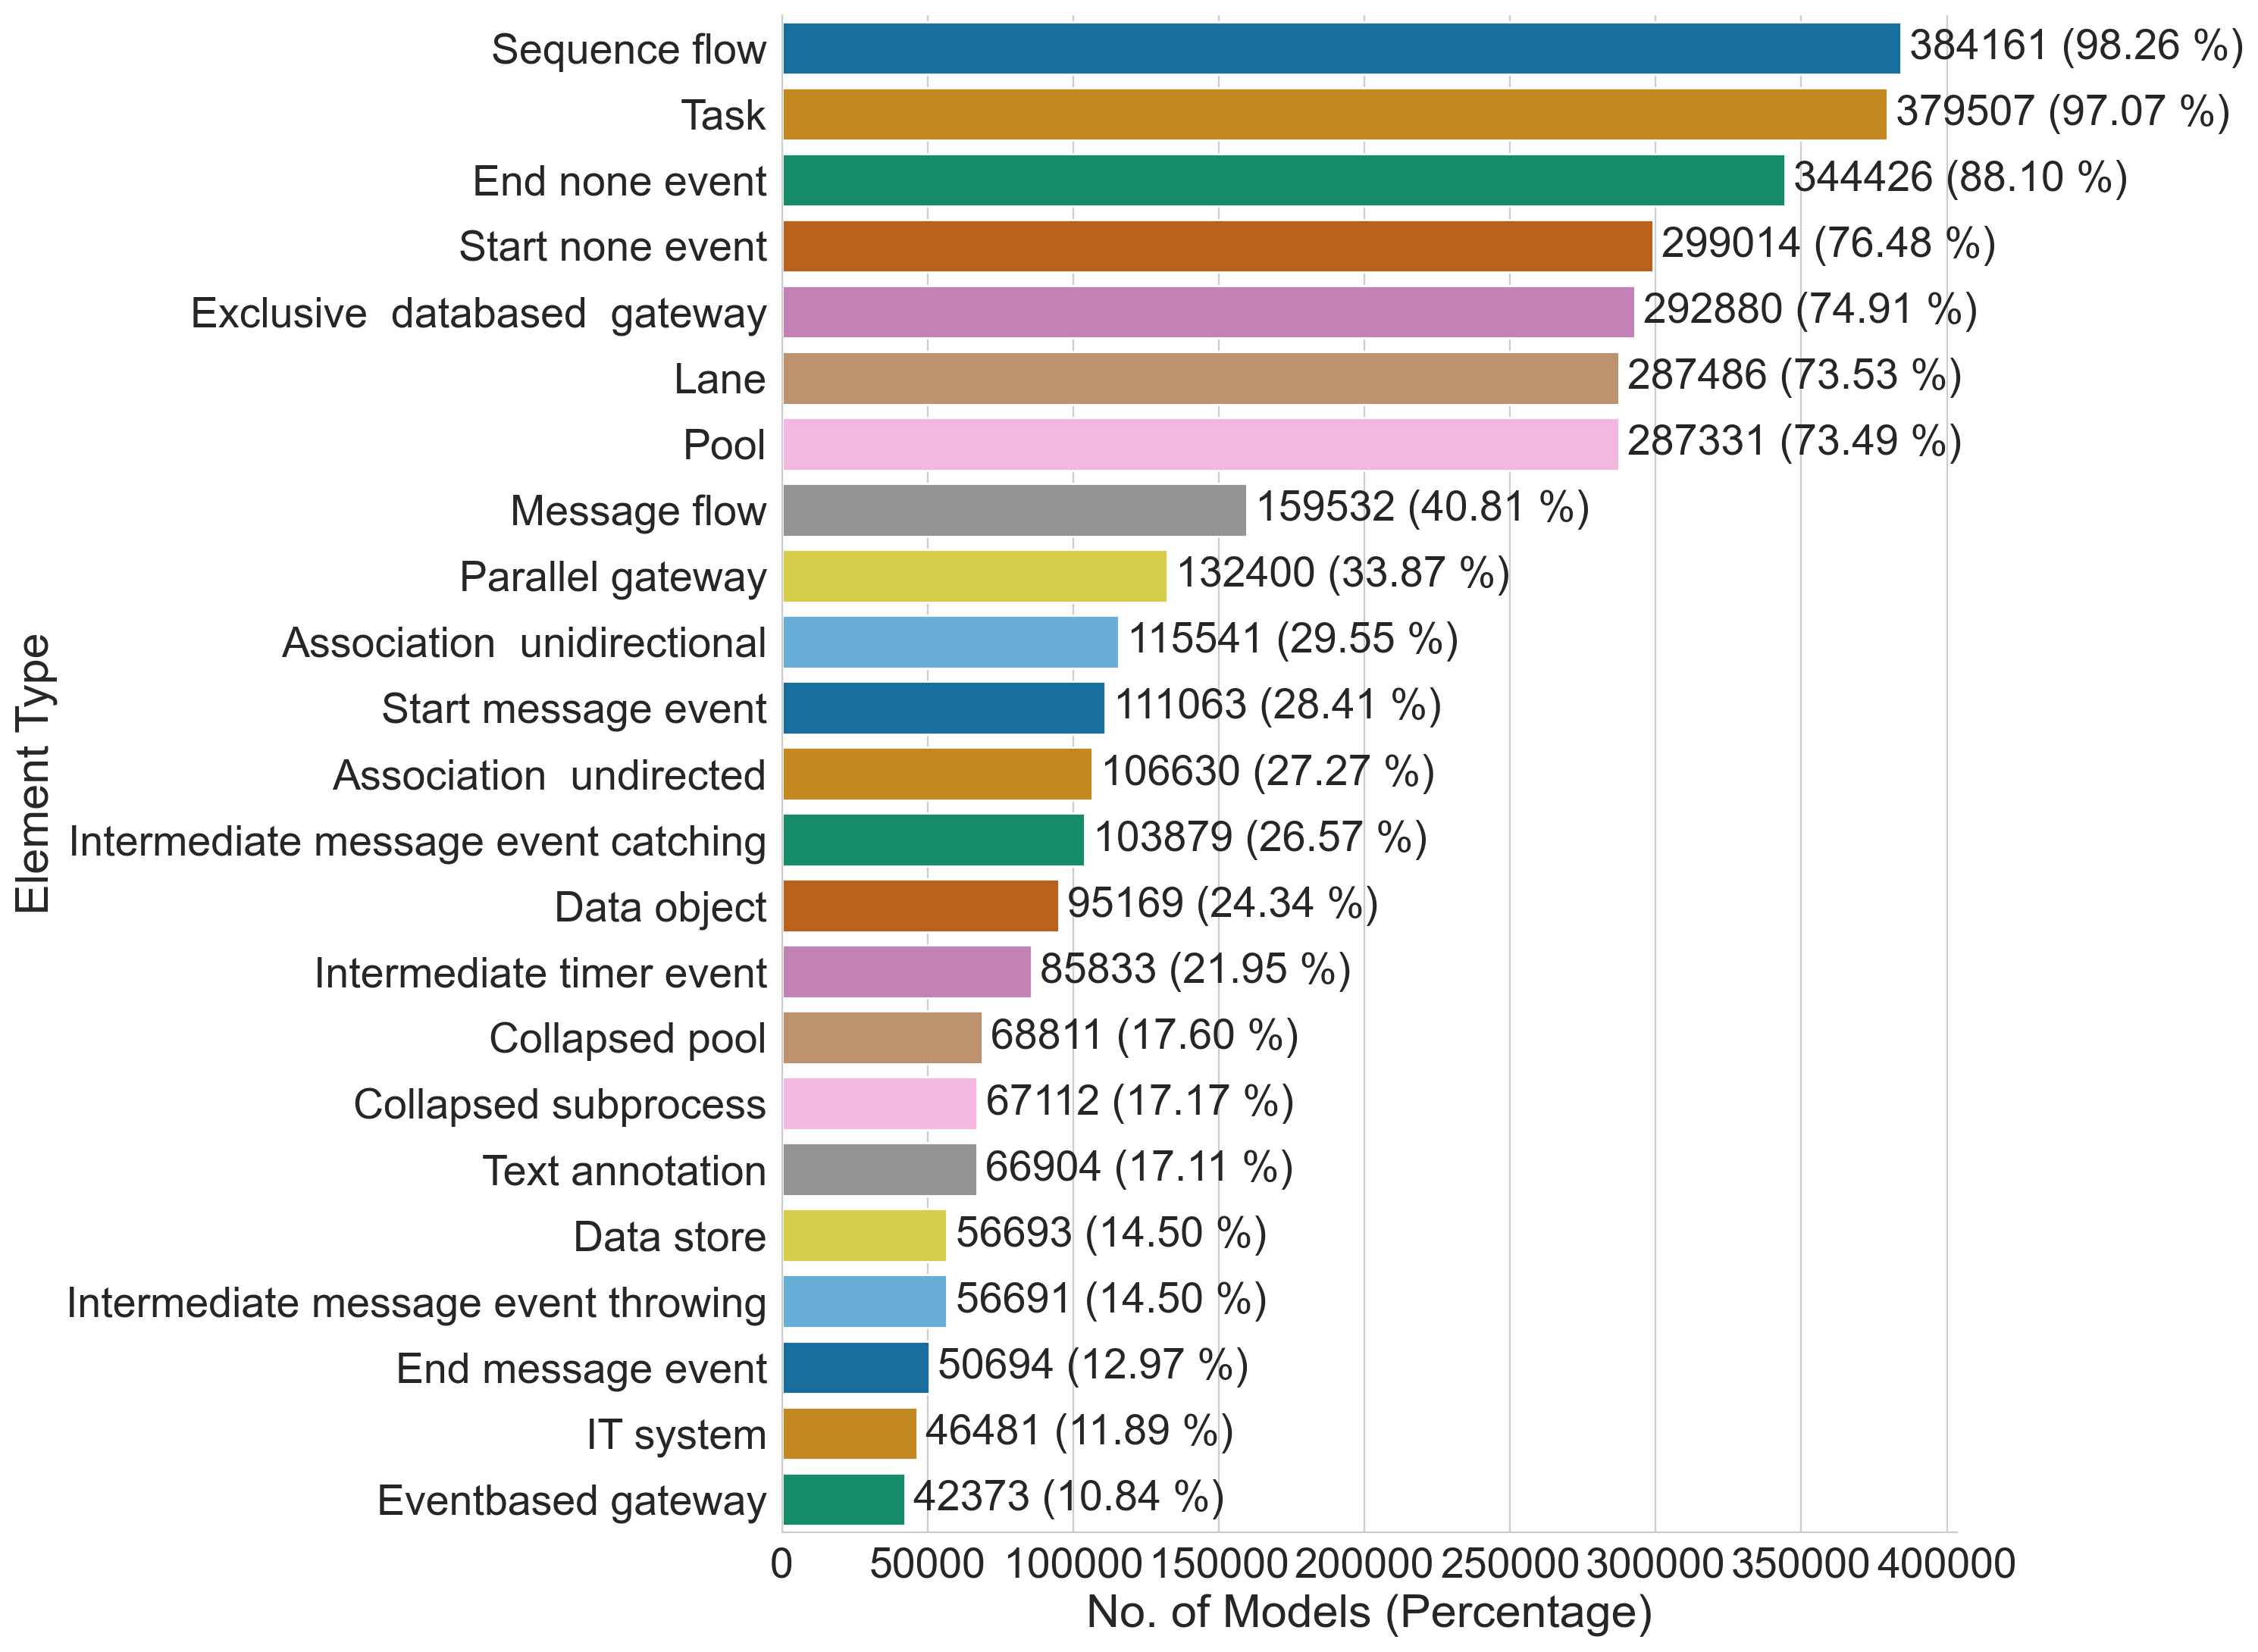

In [51]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
ax = sns.barplot(x="frequency", y="category", data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind"));
total = len(df_cnts)
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_freq['frequency']])
sns.despine()
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [52]:
df_bpmn.head()

category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                           name  
model_id                         element_id                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  Pivo  
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Pivo  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  Pivo

First, we calculate and visualize the total counts of business objects in the dataset.

In [53]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [54]:
total_bos_count = len(total_bos)
total_bos_count

154720

When compared to the total number of elements, that would be about:

In [55]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

0.78%


Next, let's take a look at how many models have at least one glossary link.

In [56]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [57]:
len(models_w_bos)

47160

The highest number of glossary links used in one model:

In [58]:
models_w_bos.max()

457

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [59]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

45146

In [60]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

29.18%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

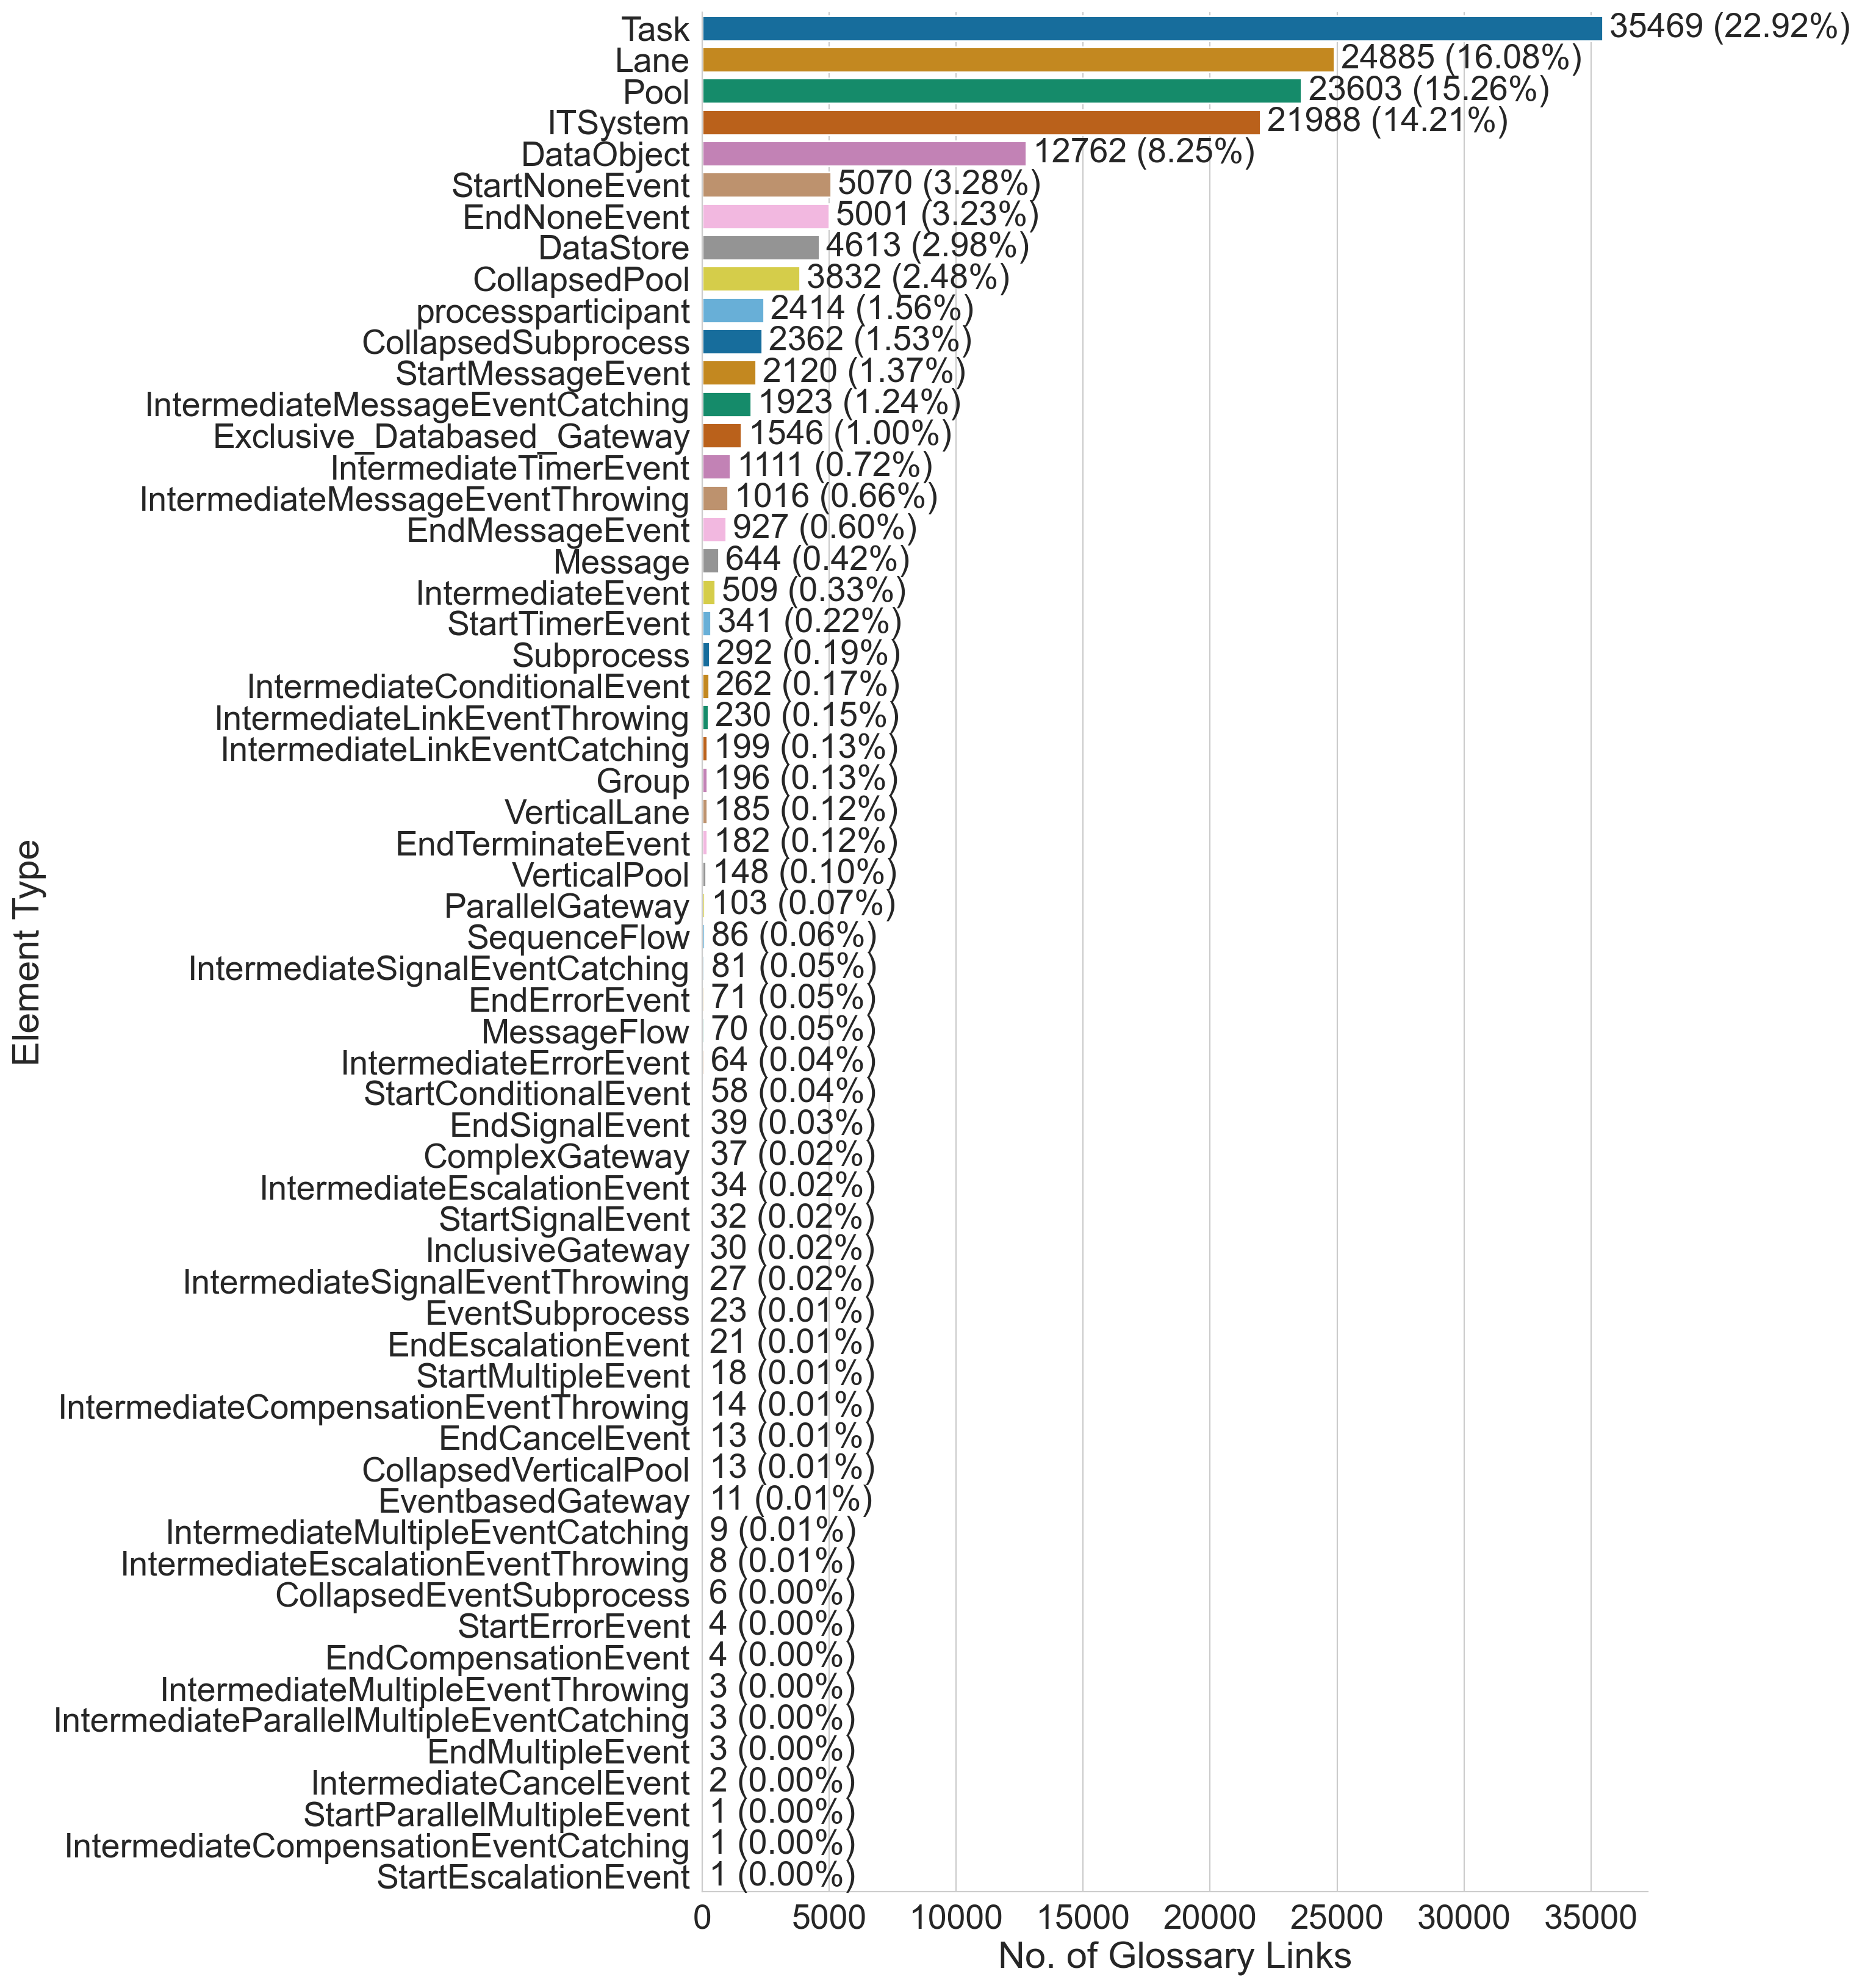

In [61]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind"))
total = total_bos_count
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val.get_width()} ({val.get_width()/total*100.0:.2f}%)' for val in ax.containers[0]])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particularly interesting category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [62]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [63]:
len(its_bos_count)

9388

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [64]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

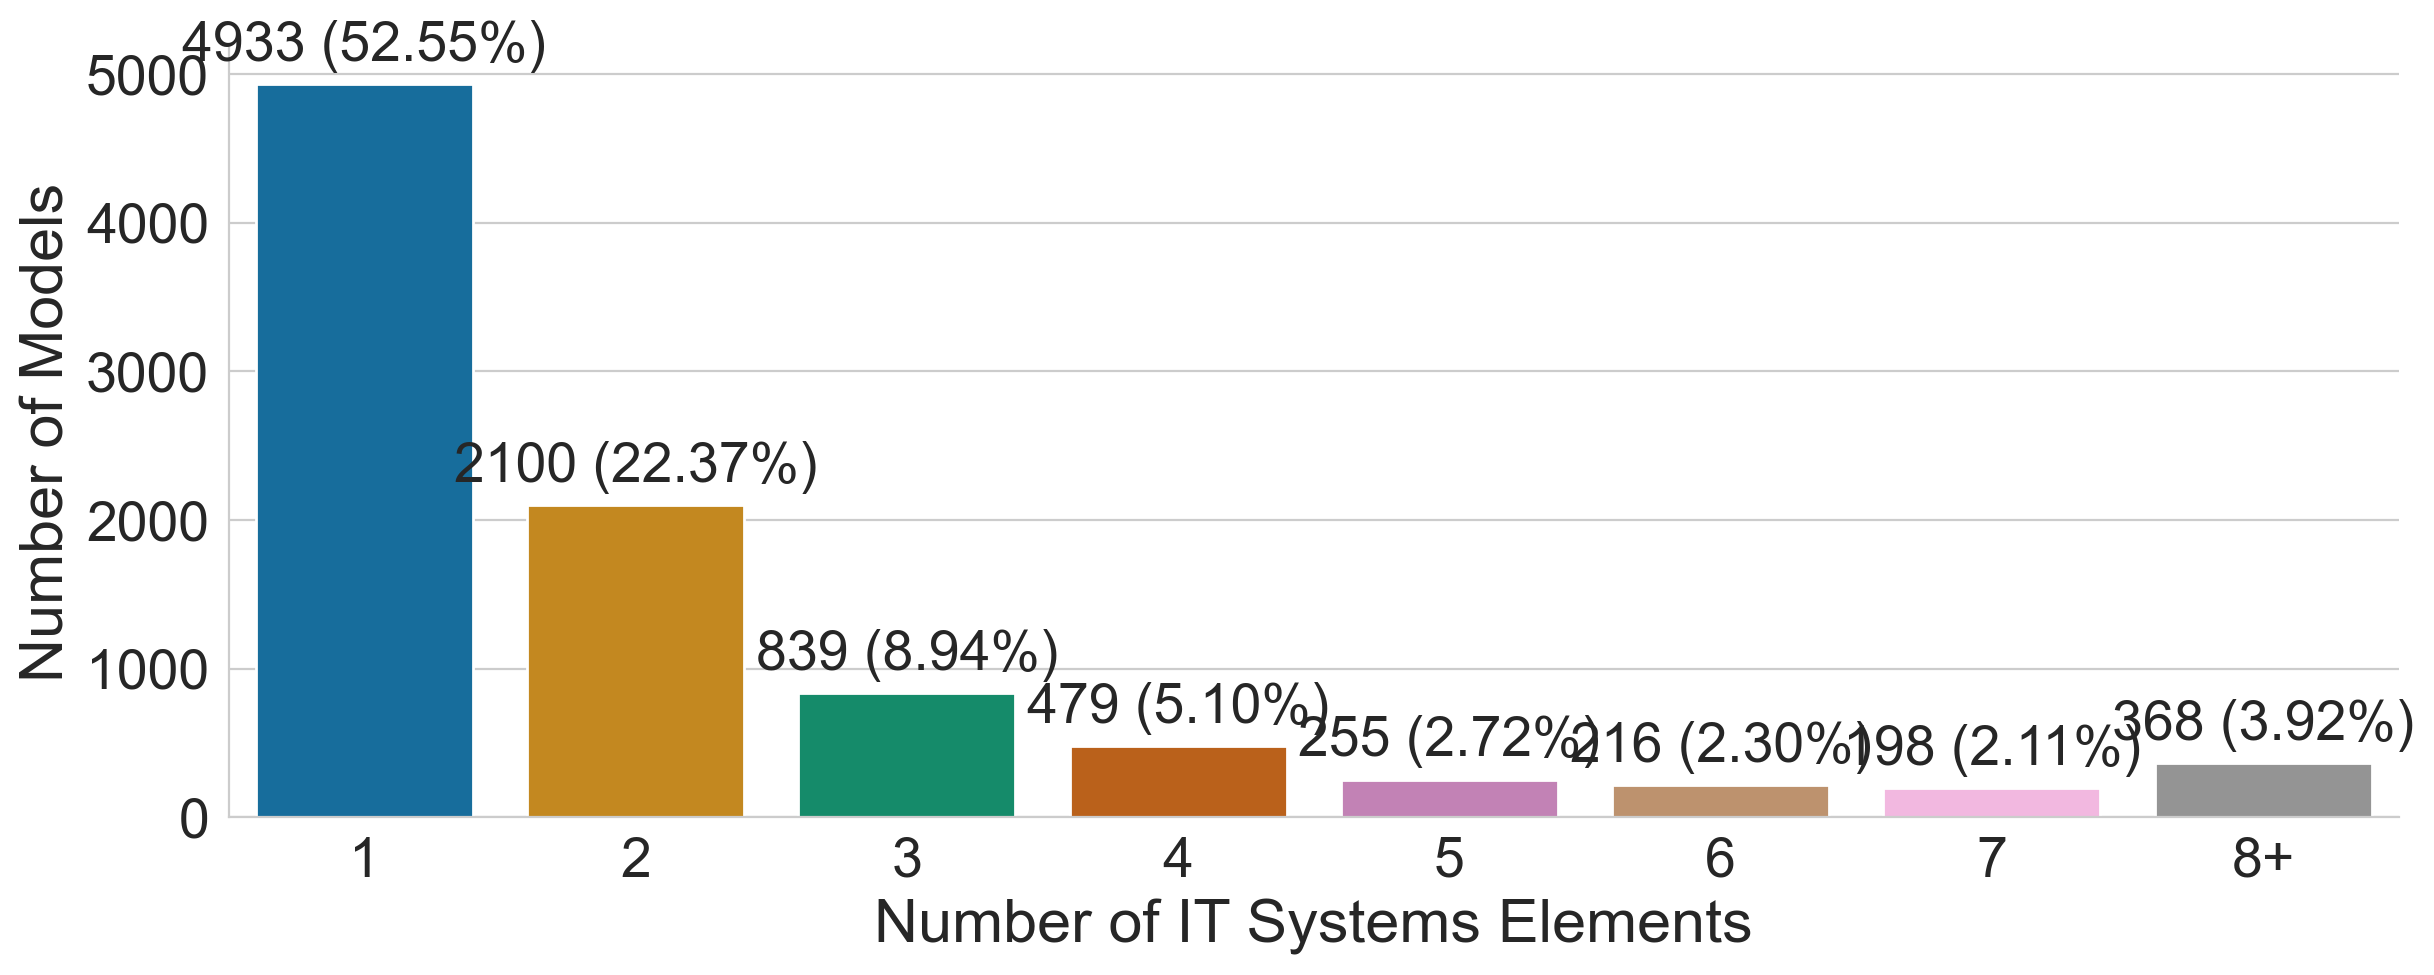

In [65]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,palette=sns.color_palette("colorblind"))
    total = len(its_bos_count)
    ax.bar_label(ax.containers[0],label_type='edge', padding=4,labels=[f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values])
    sns.despine()
    ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [66]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

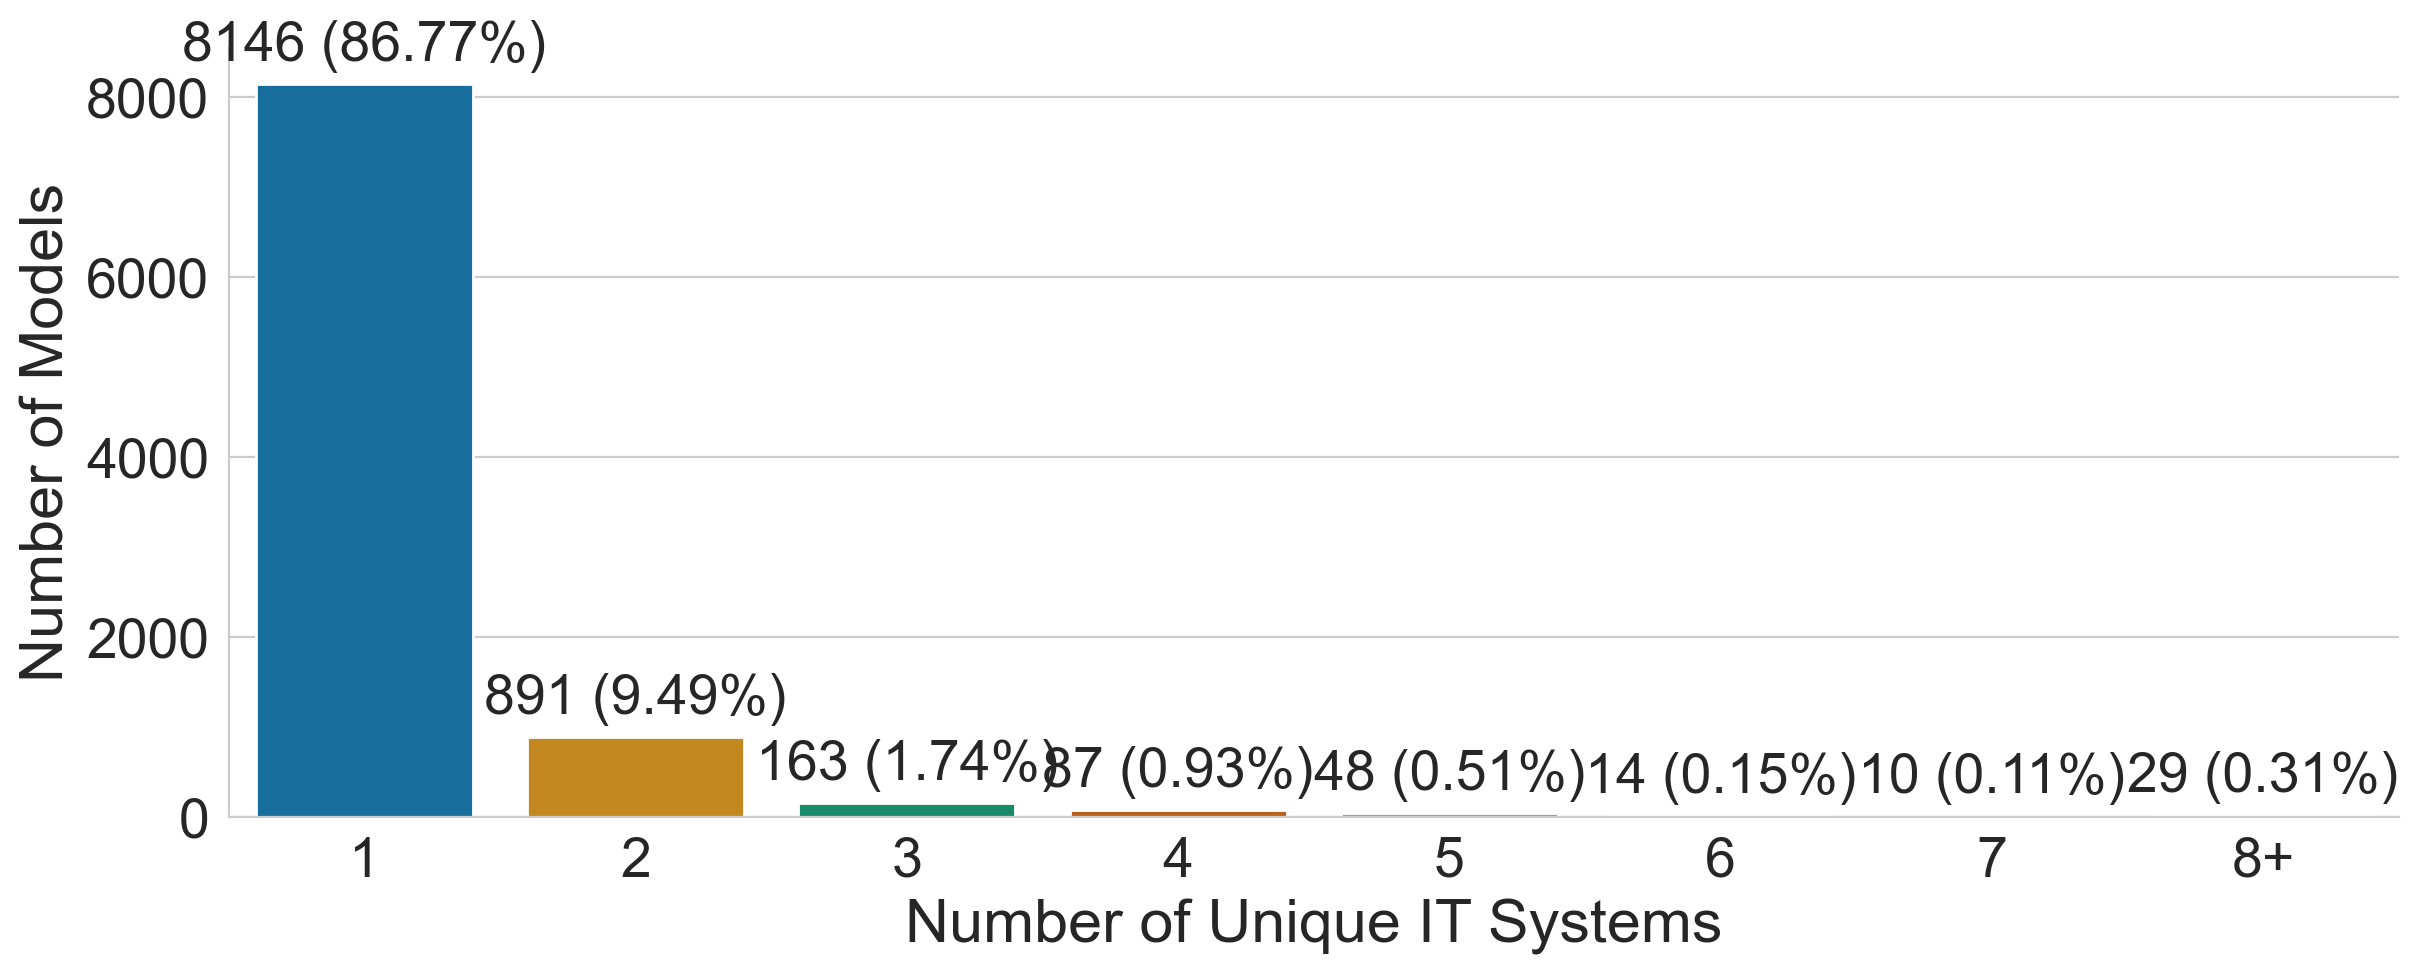

In [67]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,palette=sns.color_palette("colorblind"))
    total = len(its_bos)
    ax.bar_label(ax.containers[0],label_type='edge',padding=4,labels=[f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values])
    sns.despine()
    ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As a conclusion, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [68]:
cnt_elements.total_count.describe()

count    390954.000000
mean         50.641495
std          51.169620
min           1.000000
25%          22.000000
50%          38.000000
75%          63.000000
max        3939.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [69]:
cnt_elements.describe().transpose()

count       mean        std  \
MessageFlow                                390954.0   2.043130   3.759407   
Pool                                       390954.0   1.173644   1.125617   
Lane                                       390954.0   2.117397   2.032414   
StartMessageEvent                          390954.0   0.408703   0.931688   
SequenceFlow                               390954.0  19.948283  19.793937   
EventbasedGateway                          390954.0   0.163725   0.584697   
Task                                       390954.0   9.553454   9.726769   
StartNoneEvent                             390954.0   0.926661   0.869413   
total_count                                390954.0  50.641495  51.169620   
EndNoneEvent                               390954.0   1.758585   1.749309   
Exclusive_Databased_Gateway                390954.0   2.952769   4.283581   
Association_Undirected                     390954.0   1.225975   5.430349   
Association_Unidirectional                 390954.0   1.572303   4.757417   
IntermediateMessageEventCatching           390954.0   0.771610   2.000524   
IntermediateMessageEventThrowing           390954.0   0.409094   1.436865   
ITSystem                                   390954.0   0.370404   1.764497   
ParallelGateway                            390954.0   0.872402   1.728079   
StartConditionalEvent                      390954.0   0.016135   0.167558   
DataObject                                 390954.0   0.979926   3.647252   
IntermediateConditionalEvent               390954.0   0.041736   0.392106   
CollapsedSubprocess                        390954.0   0.403943   1.333602   
EndTerminateEvent                          390954.0   0.094234   0.494556   
IntermediateTimerEvent                     390954.0   0.405109   1.039684   
CollapsedPool                              390954.0   0.260946   0.682261   
TextAnnotation                             390954.0   0.621692   4.465518   
Subprocess                                 390954.0   0.110008   0.555450   
IntermediateEvent                          390954.0   0.078076   0.726952   
InclusiveGateway                           390954.0   0.161863   0.670338   
DataStore                                  390954.0   0.313093   1.155066   
EndMessageEvent                            390954.0   0.239601   0.821720   
EventSubprocess                            390954.0   0.026819   0.316787   
StartTimerEvent                            390954.0   0.074073   0.349298   
IntermediateErrorEvent                     390954.0   0.060925   0.357012   
IntermediateLinkEventCatching              390954.0   0.017171   0.198856   
IntermediateLinkEventThrowing              390954.0   0.020227   0.239804   
Message                                    390954.0   0.115246   0.912074   
Group                                      390954.0   0.024936   0.352375   
processparticipant                         390954.0   0.046847   0.721053   
Association_Bidirectional                  390954.0   0.042153   0.486352   
IntermediateEscalationEvent                390954.0   0.010676   0.146506   
EndEscalationEvent                         390954.0   0.008799   0.119187   
EndErrorEvent                              390954.0   0.032513   0.239941   
IntermediateMultipleEventCatching          390954.0   0.010894   0.145992   
IntermediateSignalEventThrowing            390954.0   0.011045   0.197906   
StartMultipleEvent                         390954.0   0.004533   0.074123   
EndSignalEvent                             390954.0   0.011513   0.186904   
StartSignalEvent                           390954.0   0.009515   0.148010   
IntermediateCancelEvent                    390954.0   0.005545   0.109737   
IntermediateCompensationEventCatching      390954.0   0.013562   0.175008   
EndCancelEvent                             390954.0   0.016145   0.176797   
ComplexGateway                             390954.0   0.007881   0.136372   
VerticalPool                              

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [70]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [71]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min   25%   50%   75%  \
Activities          390954.0  10.098602   9.988681  0.0   4.0   8.0  13.0   
Artifacts           390954.0   1.017033   4.926035  0.0   0.0   0.0   1.0   
Connecting Objects  390954.0  24.831845  26.905600  0.0  10.0  18.0  31.0   
Data Elements       390954.0   1.408265   4.218914  0.0   0.0   0.0   1.0   
Events              390954.0   5.501248   6.233078  0.0   2.0   3.0   6.0   

                       max  
Activities          1543.0  
Artifacts            529.0  
Connecting Objects  2066.0  
Data Elements        266.0  
Events               157.0

In [72]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%     max
Activities          10.1  10.0  0.0   4.0   8.0  13.0  1543.0
Artifacts            1.0   4.9  0.0   0.0   0.0   1.0   529.0
Connecting Objects  24.8  26.9  0.0  10.0  18.0  31.0  2066.0
Data Elements        1.4   4.2  0.0   0.0   0.0   1.0   266.0
Events               5.5   6.2  0.0   2.0   3.0   6.0   157.0
Gateways             4.2   5.3  0.0   1.0   3.0   6.0   303.0
Swimlanes            3.6   3.1  0.0   0.0   4.0   5.0   227.0

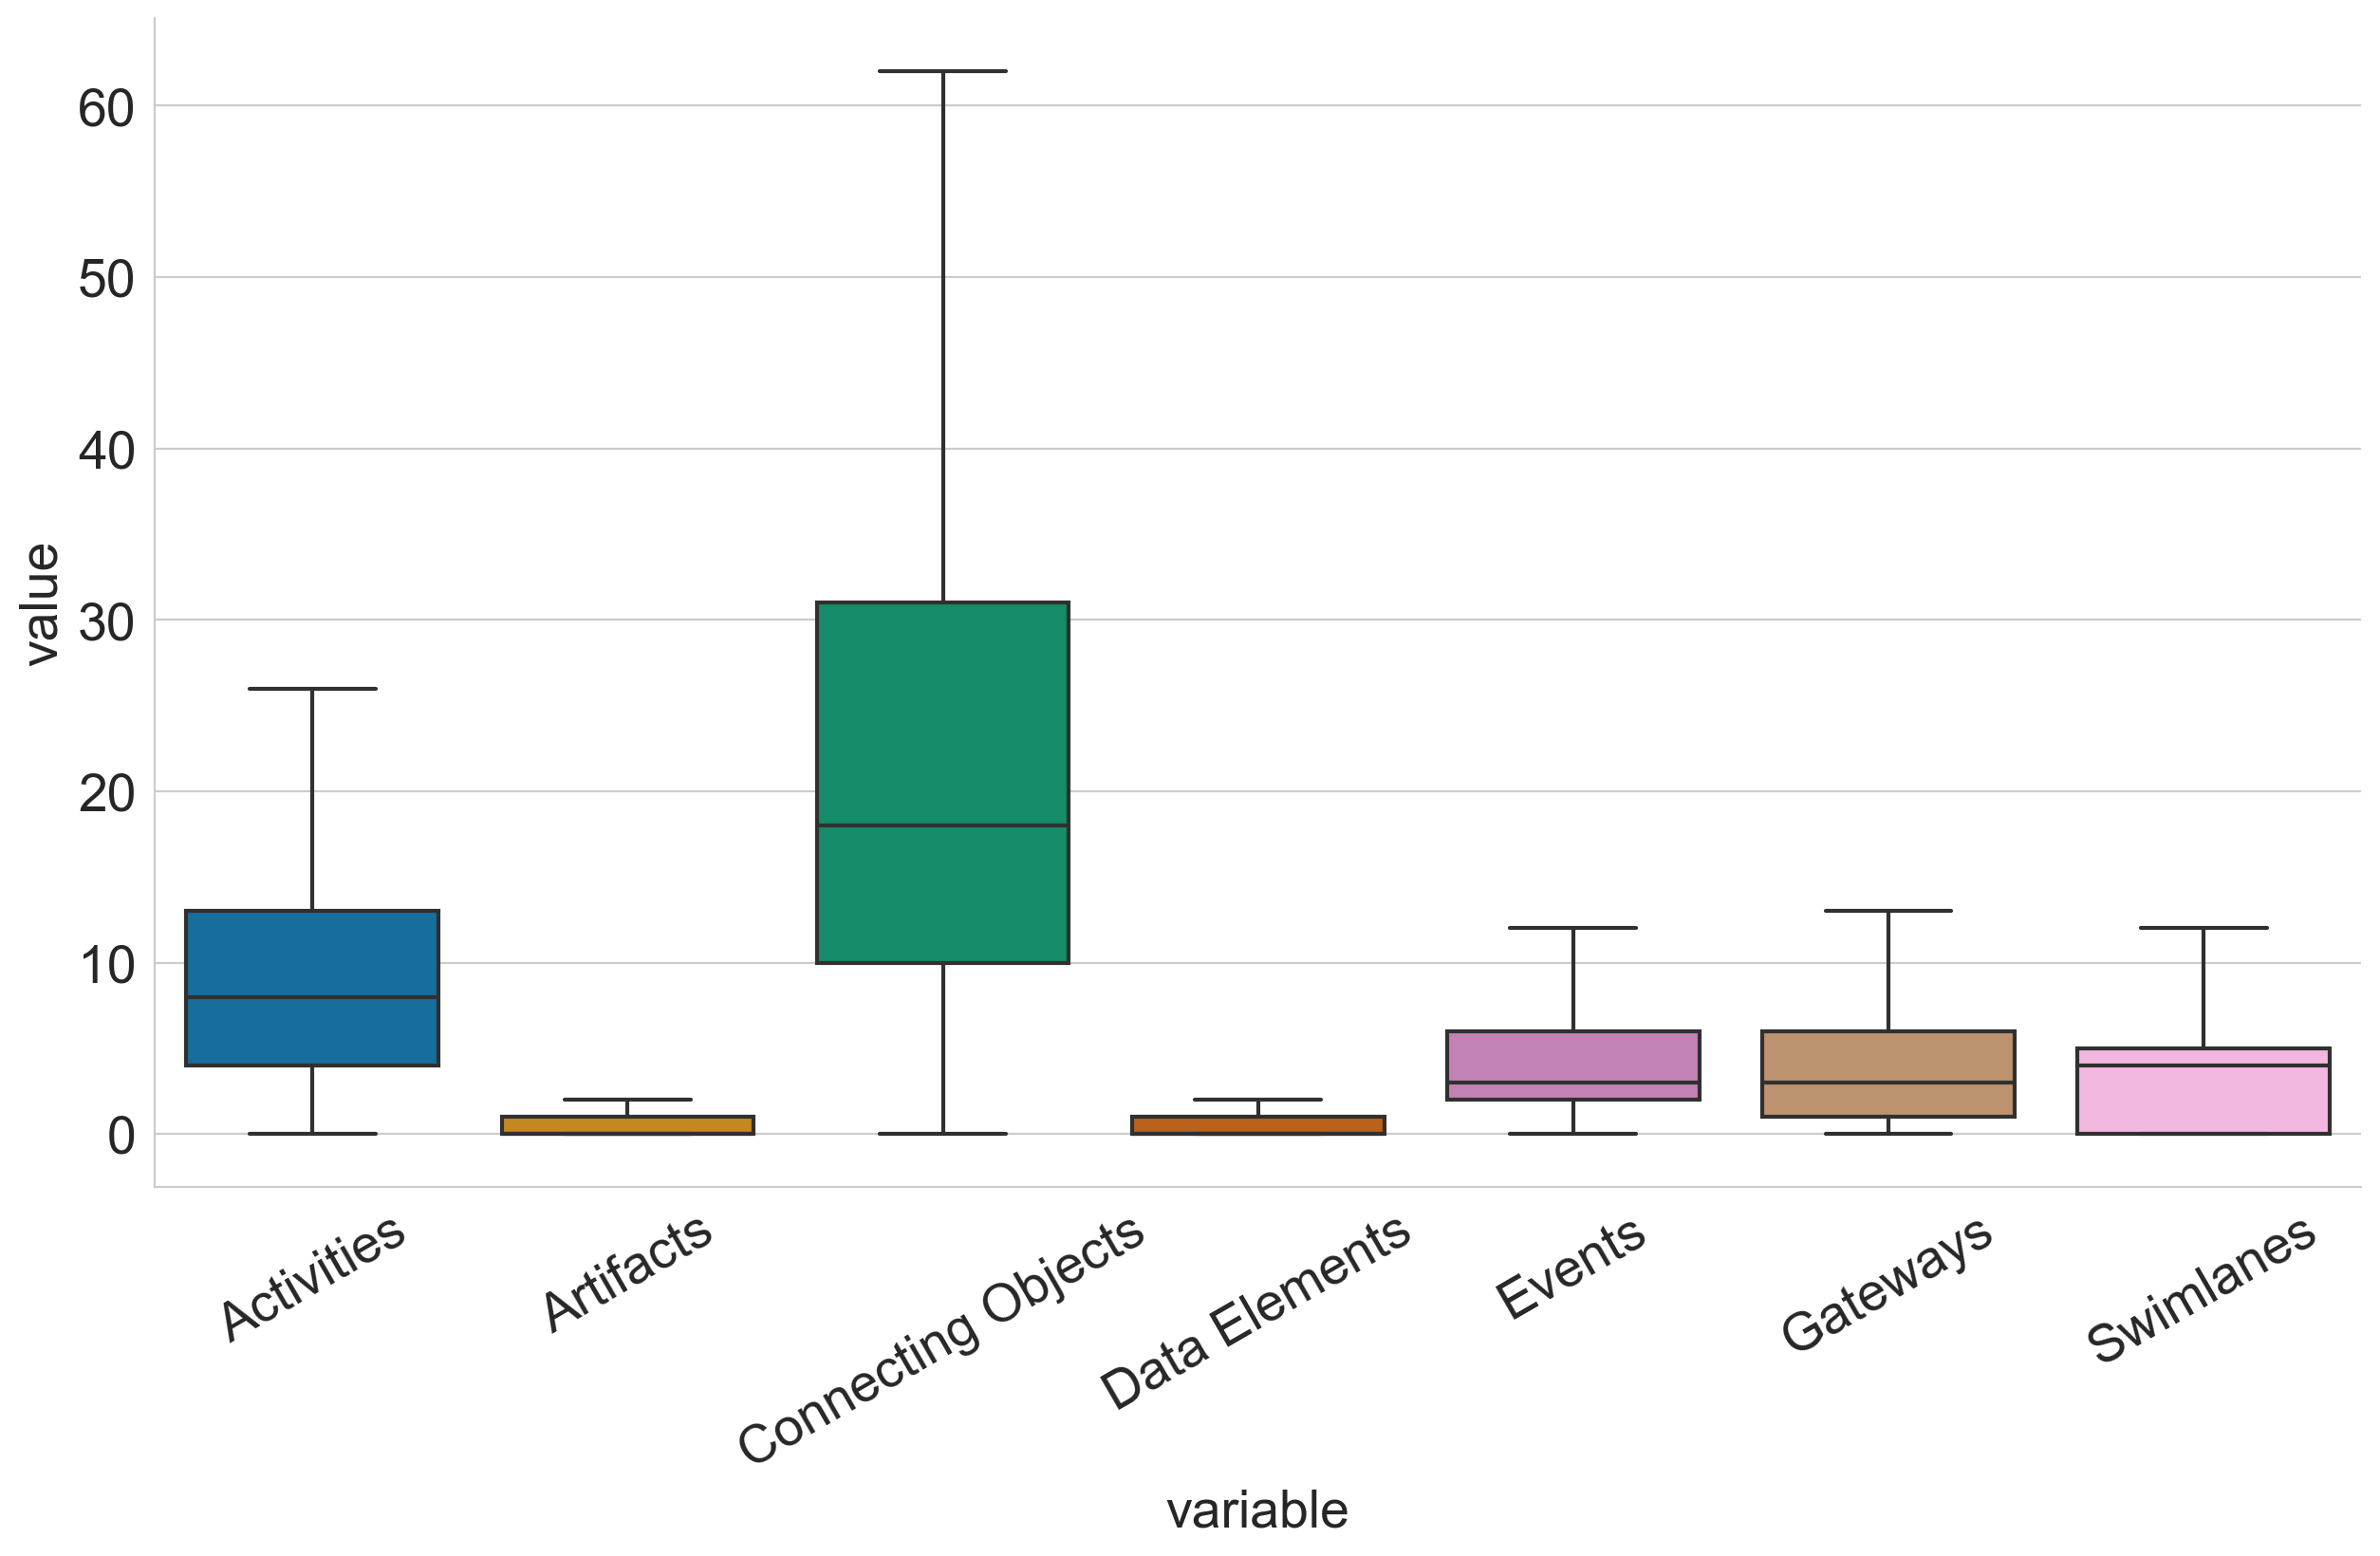

In [73]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [74]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min   25%   50%   75%     max
No. of Edges  390954.0  24.831845  26.905600  0.0  10.0  18.0  31.0  2066.0
No. of Nodes  390954.0  25.808609  24.495668  0.0  12.0  20.0  32.0  1873.0

In [75]:
df_high_level.head()

No. of Edges  No. of Nodes
0             3             9
1            17            21
2             6             7
3            29            37
4             5             8

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

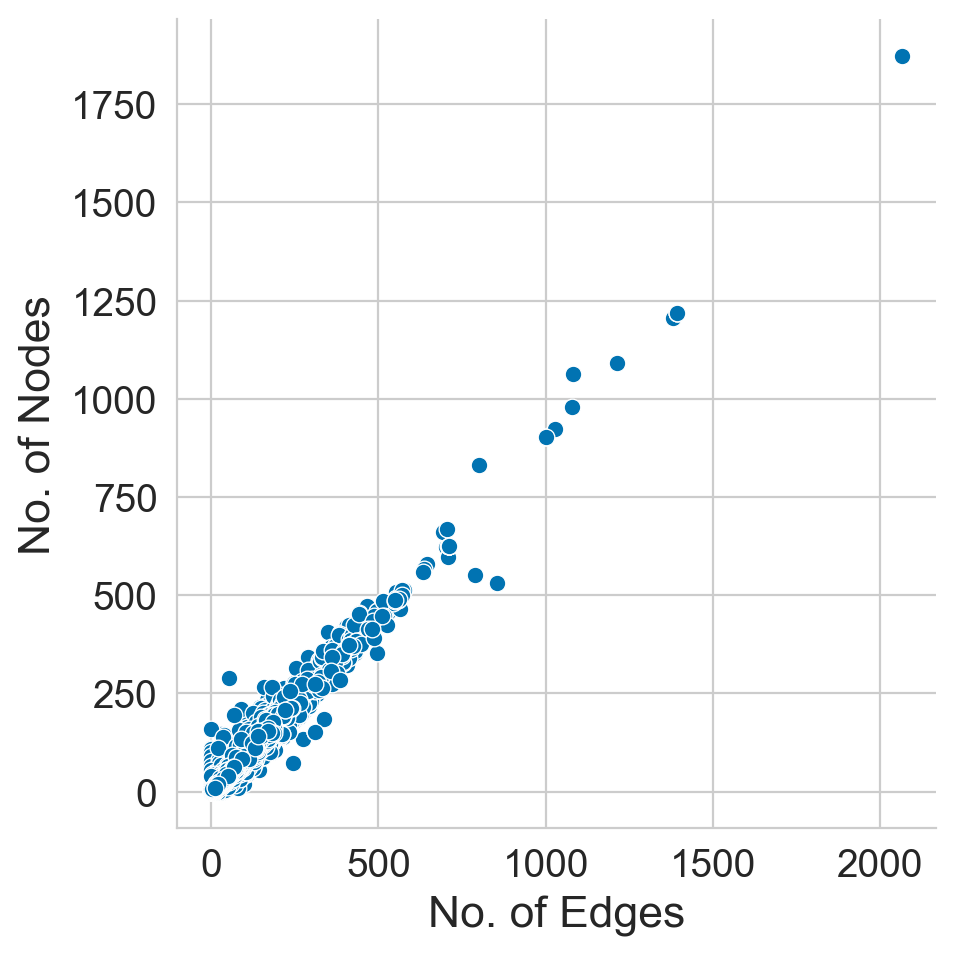

In [76]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
#plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [77]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [78]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0            12345678        24296
1         New Process        13268
2       Neuer Prozess         4756
3       12345678_rev1         2494
4       12345678_rev2         1530
5            Jane Doe         1351
6         New Diagram         1218
7       12345678_rev3         1118
8  New Process (Copy)          746
9       12345678_rev4          745

The number of distinct process names:

In [79]:
len(cnts_names)

328280

We use Signavio's color palette for the word cloud.

In [80]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

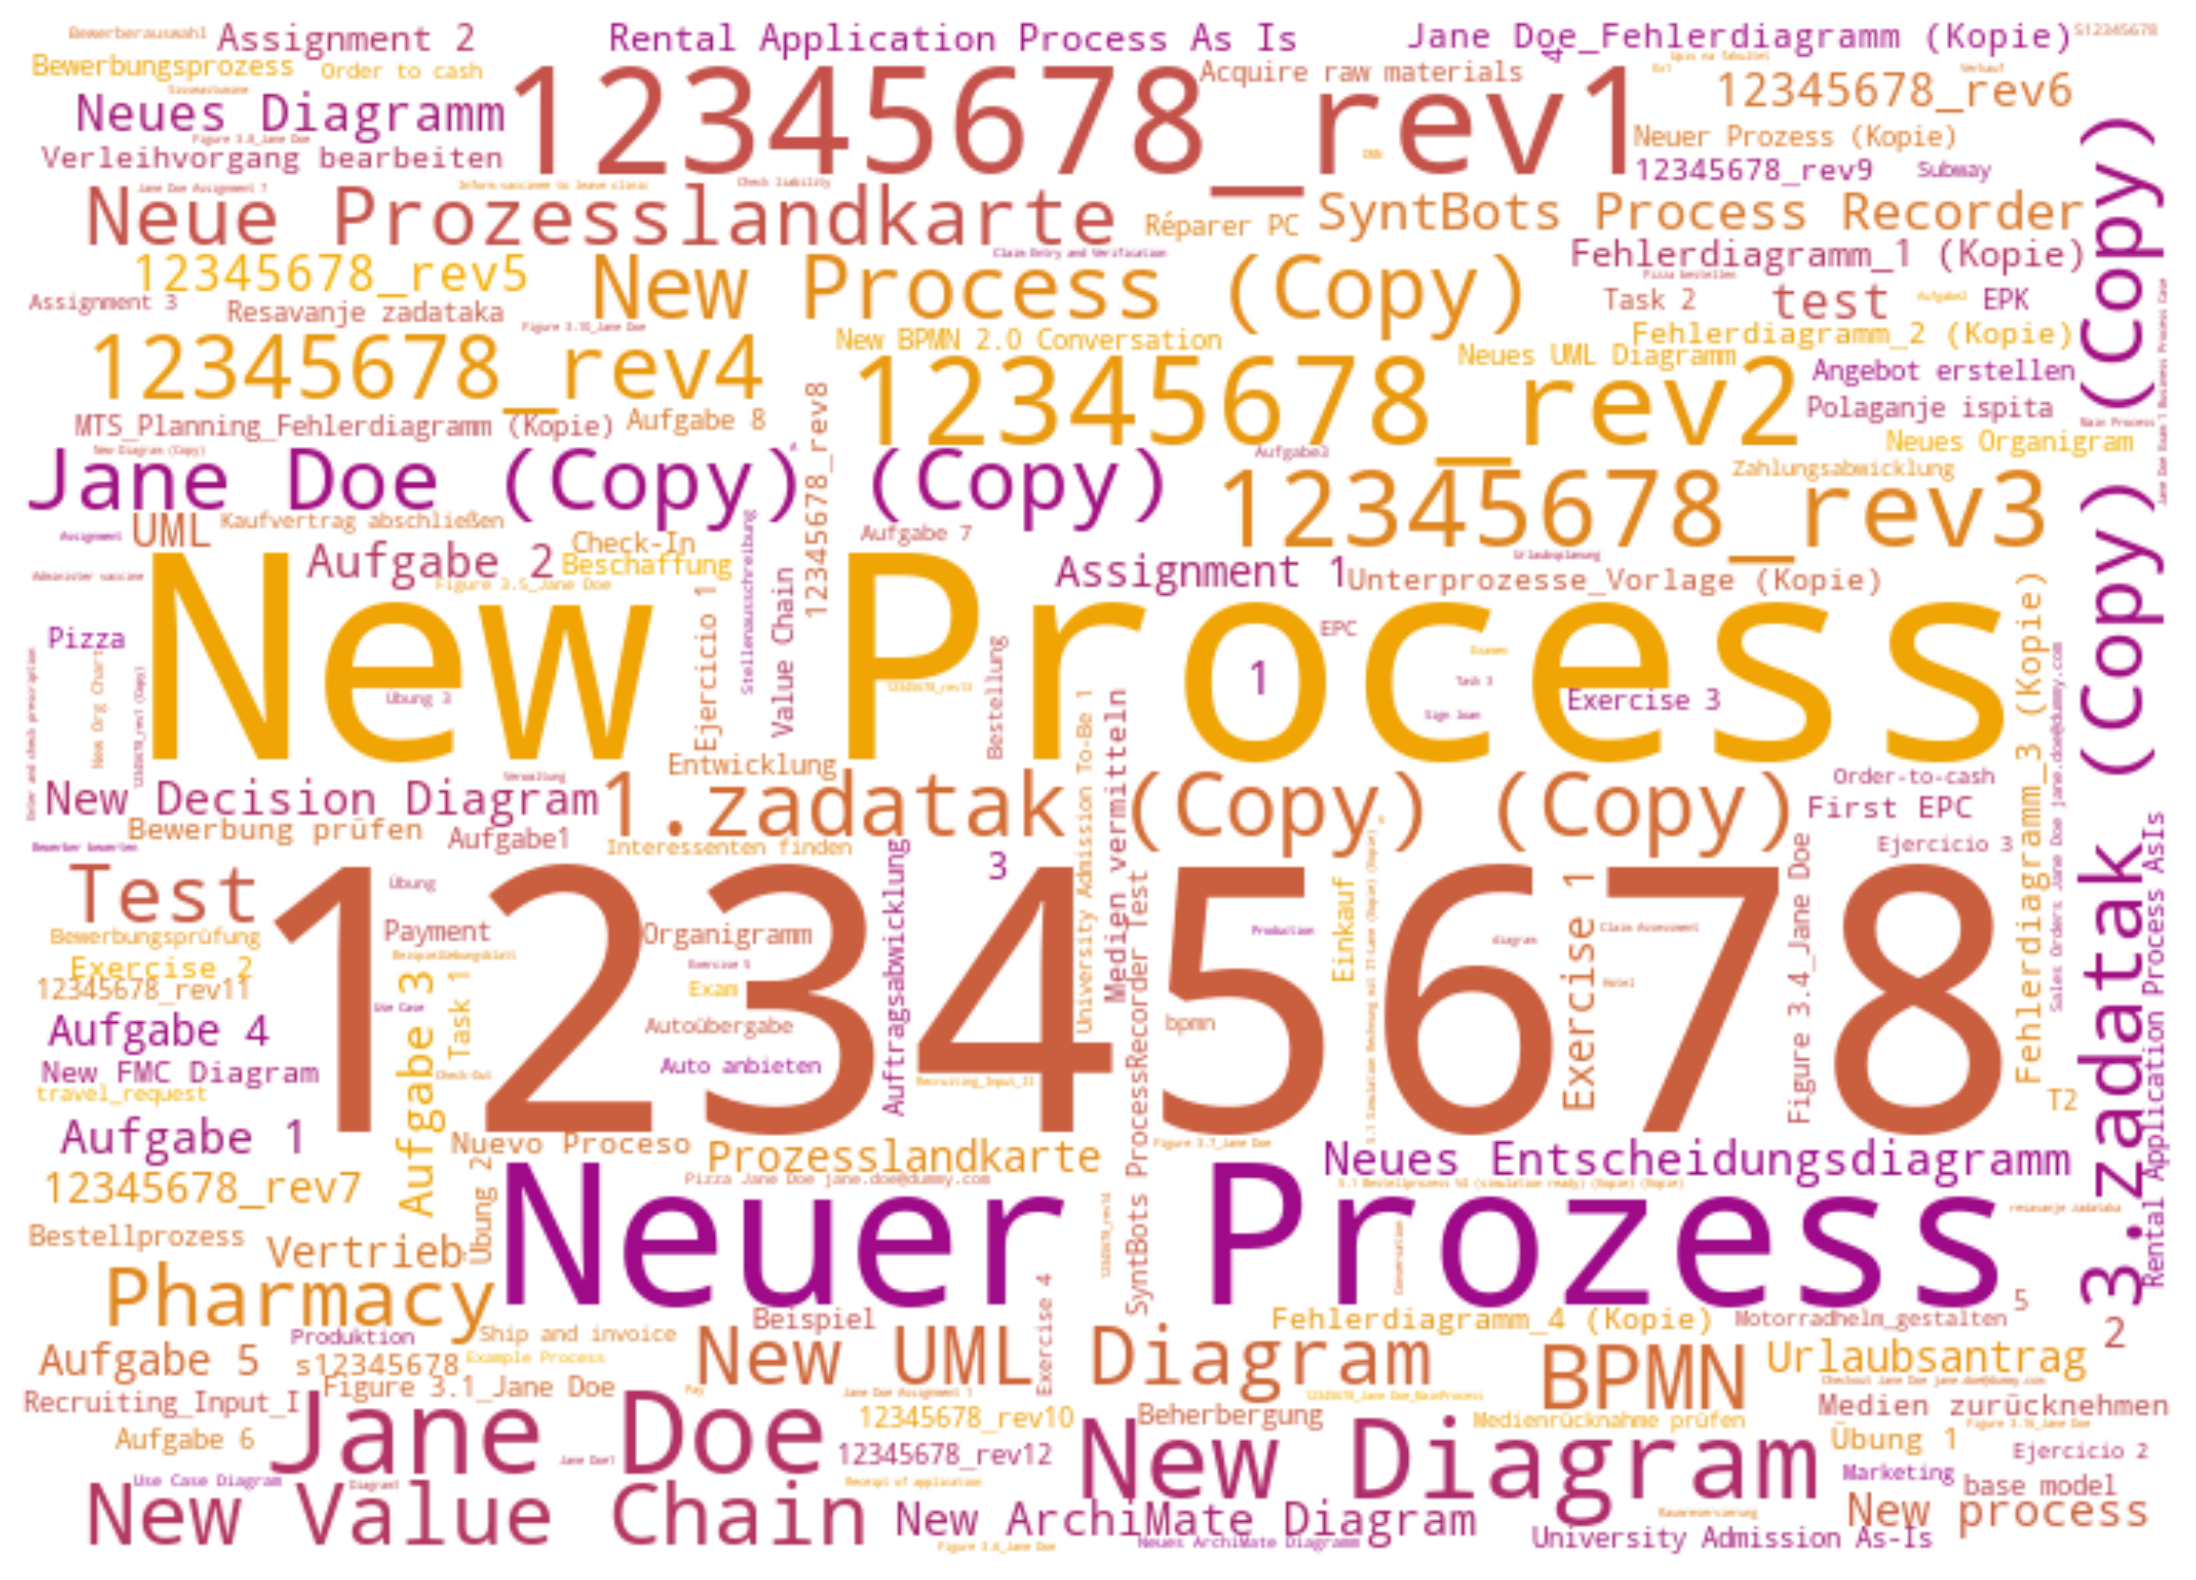

In [81]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [82]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No       115437
1       Yes        94678
2        Ja        49308
3        no        47498
4      Nein        45922
5       yes        38567
6        ja        38093
7      nein        37814
8  Customer        25178
9        NO        21676

The number of distinct element labels:

In [83]:
len(cnts_labels)

2819449

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [84]:
len(df_bpmn)

19798495

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [85]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.6192079673017705

... while 64.9 % of the labels are used for only one element.

In [86]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.6488420255163332

In [87]:
len(cnts_labels[cnts_labels.occurrences==1])

1829377

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [88]:
bins = cnts_labels
bins.head()

label  occurrences
0    No       115437
1   Yes        94678
2    Ja        49308
3    no        47498
4  Nein        45922

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [89]:
N = 10000
bins = bins.groupby(bins.index // N).sum()

In [90]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0      3016811           10000
1       458737           20000
2       286410           30000
3       211693           40000
4       170689           50000

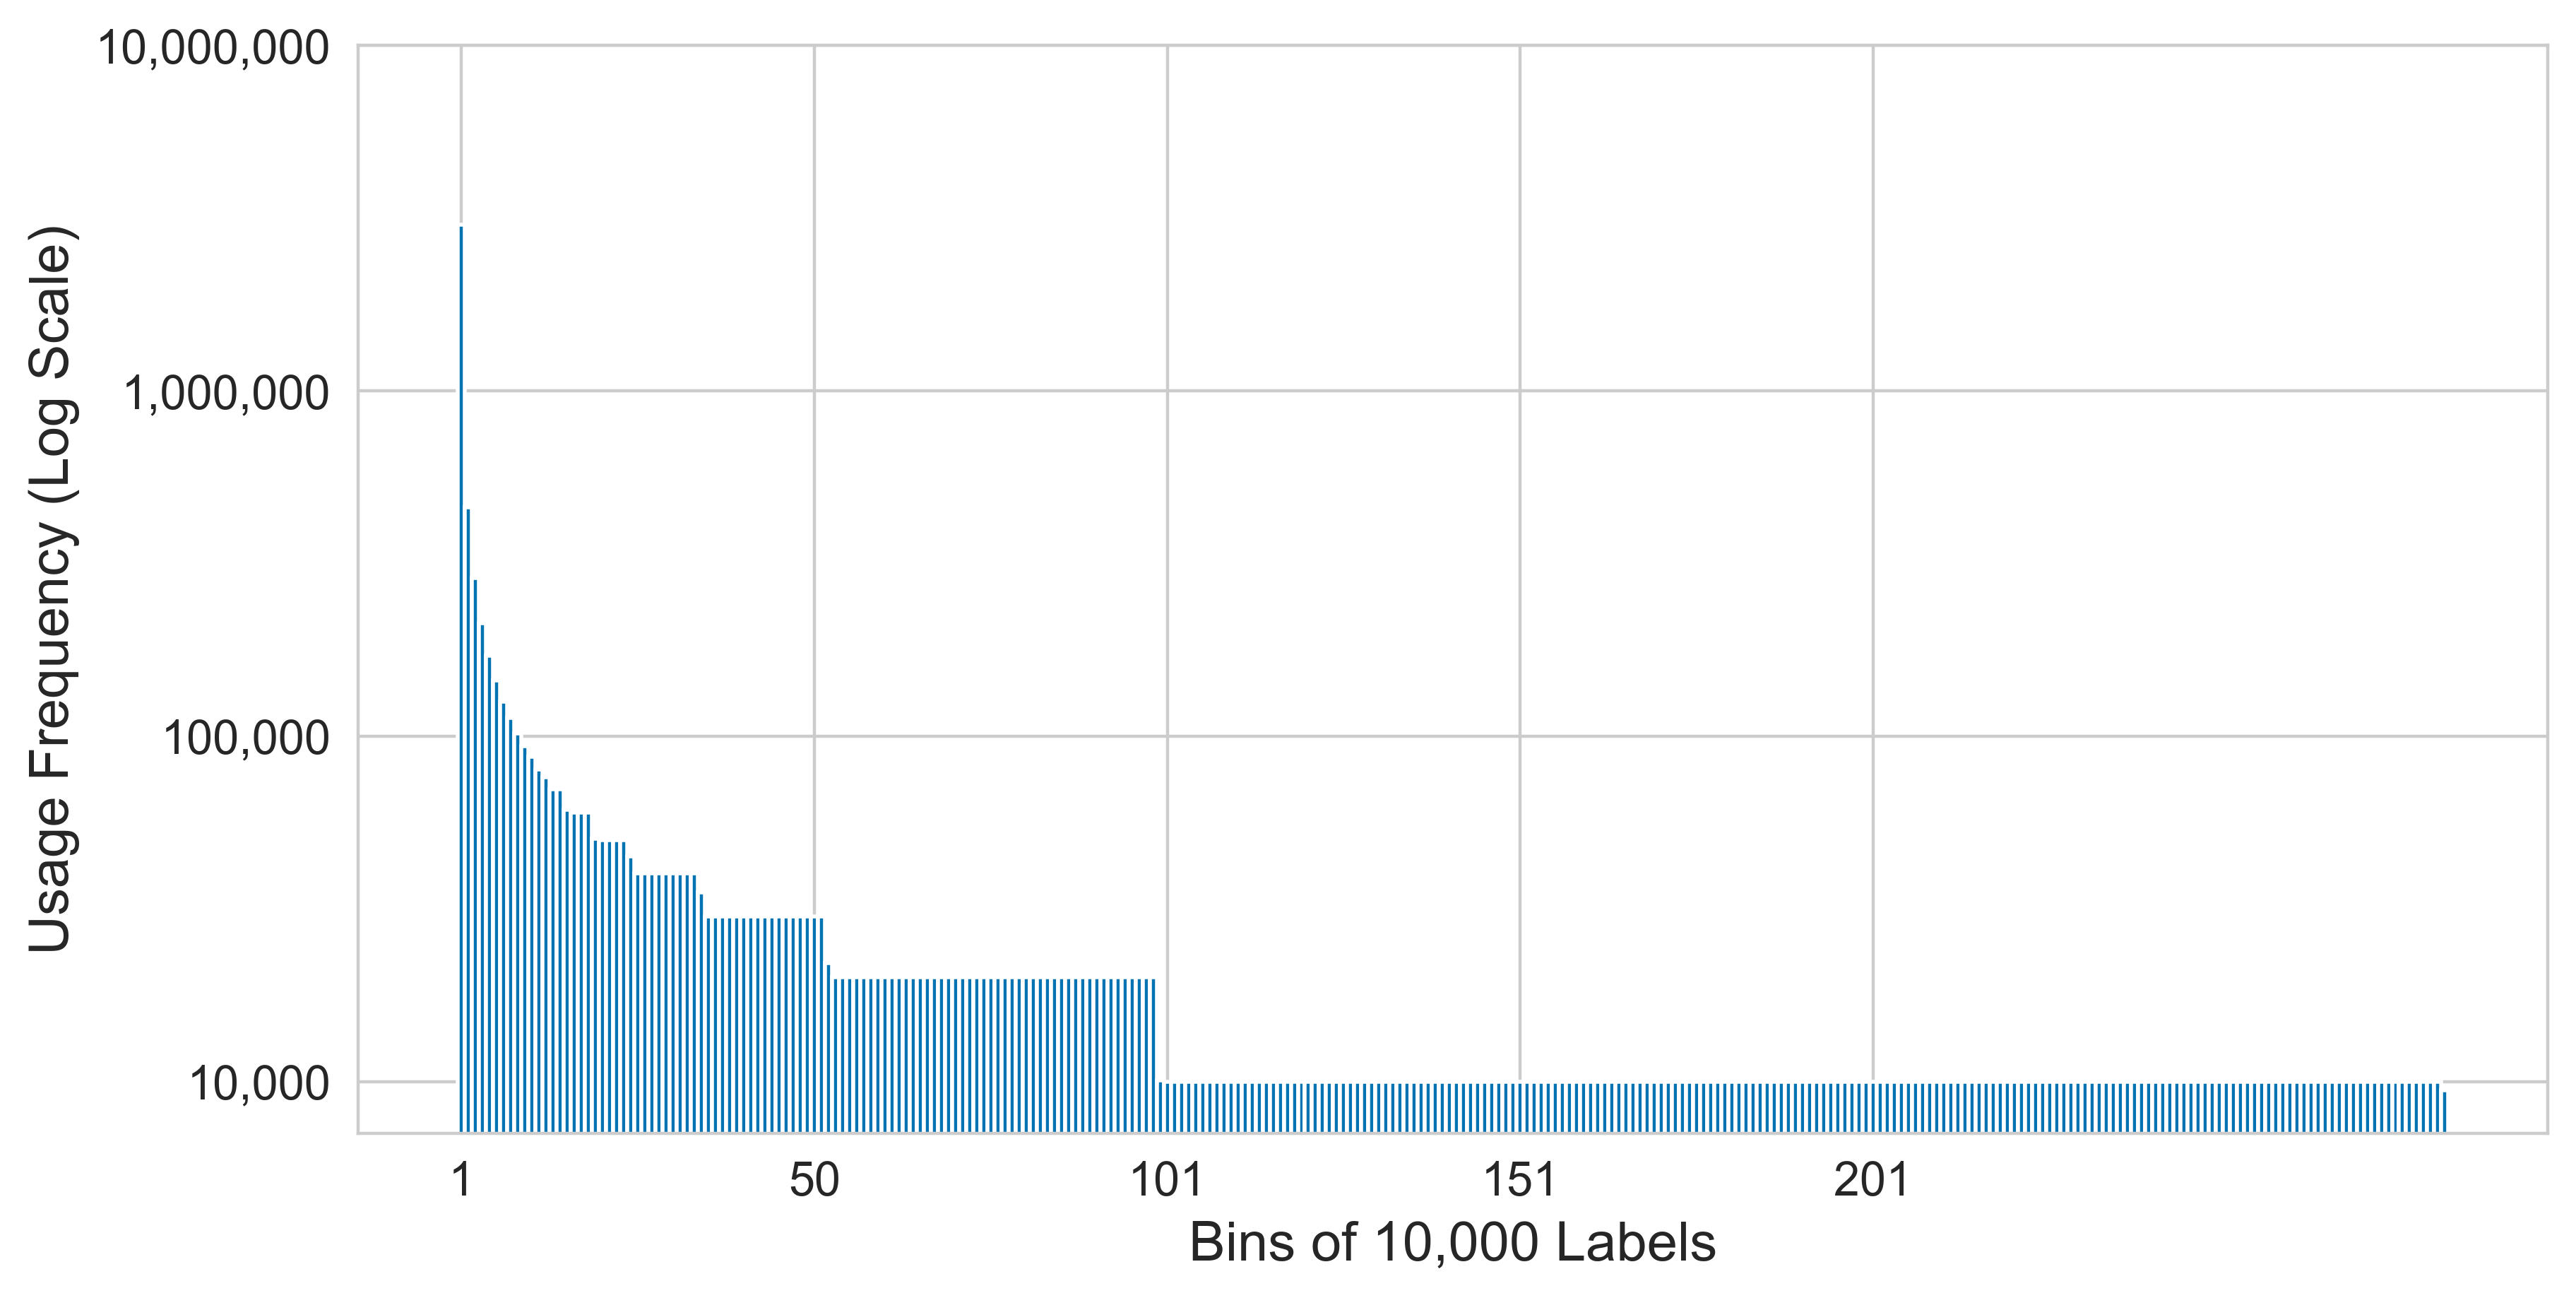

In [91]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

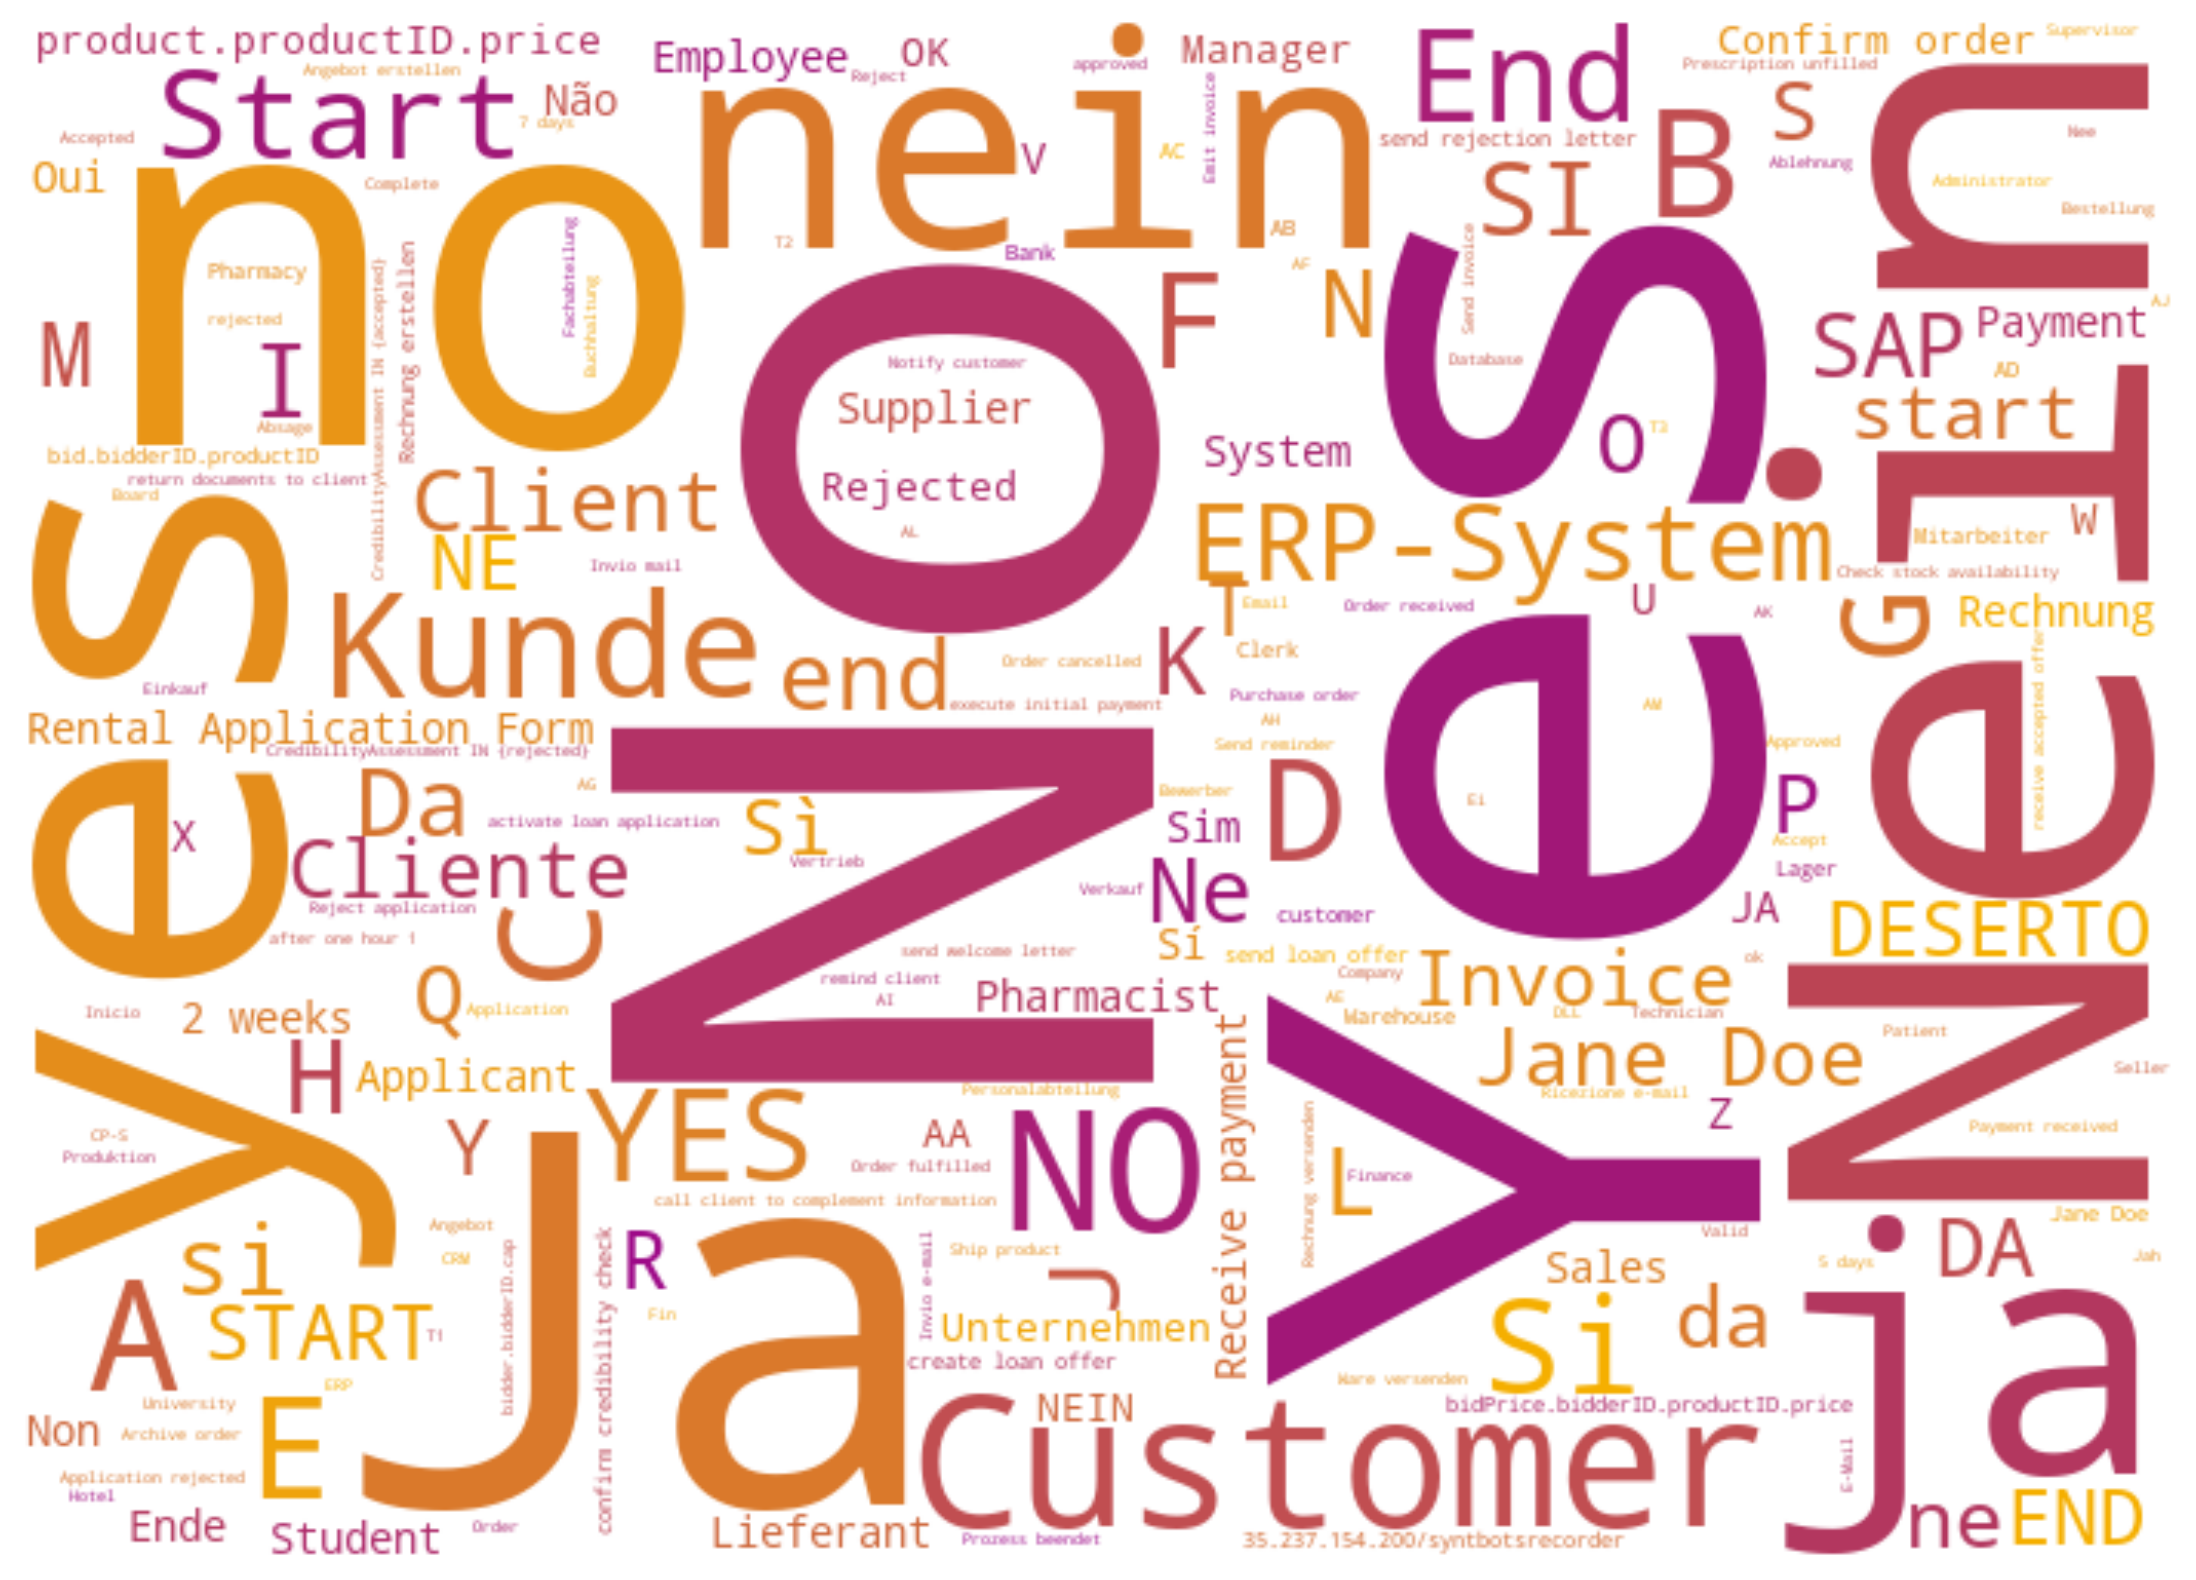

In [92]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()